# 机器学习纳米学位 
## 毕业项目:Forecast Rossmann Store Sales
Rossmann是欧洲的一家连锁药店。 在这个源自Kaggle比赛Rossmann Store Sales中，需要根据Rossmann药妆店的信息（比如促销，竞争对手，节假日）以及在过去的销售情况，来预测Rossmann未来的销售额。

建议
1、建模第一步就是分析你的数据集，包括特征分析、预测的目标分析等等；该任务是一个回归预测类问题，这里尤其要注意预测是未来的销量；
2、合理的划分你的训练集、验证集，记住你的目的是对于测试集的预测，这是需要提交到kaggle测评的；
3、模型层面的话，建议尝试GBDT类模型，例如xgboost、lightgbm等模型；
4、多多参考kaggle discussion，你能获得很多的优秀特征工程建议以及模型构建的技巧。
达到测试集rmpse为0.11773。

参考资料：

项目1波士顿房价预测
https://blog.csdn.net/sb19931201/article/details/52577592
http://www.julyedu.com/question/big/kp_id/23/ques_id/2590
https://blog.csdn.net/wgf5845201314/article/details/73739604
https://blog.csdn.net/aicanghai_smile/article/details/80987666
https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet
https://www.kaggle.com/init27/fastai-v3-lesson-6-rossmandataset/downloads/googletrend.csv/notebook


## 开始
罗斯曼在7个欧洲国家经营着3000多家药店，数以千计的管理者给出的预测都是基于它们自己特有的销售环境，所以其结果的准确性也千差万别。这个项目的任务是基于Rossmann药妆店近三年的销售历史，预测其未来六周的日销售额。而门店的销售量受到许多因素的影响，包括促销活动、竞争对手、学校和国家假日、季节性和地区性等因素。能否找到、如何找到历史数据的规律并能对未来做出不错的预测是我接下来需要思考的问题、尽力实现的目标。

这个项目的数据来自Kaggle的https://www.kaggle.com/c/rossmann-store-sales/data ，提供了1,115家Rossmann门店的历史销售数据。我们需要的结果即预测出数据集的“Sales”列，有一点需要注意，在数据集中有些门店因翻新整改处于短期的关闭状态。

我将分析数据集的内在结构，这个数据集包含四个csv文件，分别是包含销售量的历史数据集train.csv，不包含销售量的历史数据集test.csv,正确格式的提交文件示例sample_submission.csv，有关各门店的补充信息store.csv。

其中数据的特征标签需要说明的有：
Id——测试集中关于二元组（门店，日期）的Id。

Store——每个门店的唯一Id。

Customers——某一天的客户数量。

Open——表示门店是否开业：0表示关闭，1表示开业。

StateHoliday——表示国家假日。正常情况下，除了少数例外，所有商店在国定假日都不营业。请注意，所有学校在公众假期和周末休课。a=公众假期，b=复活节假期，c=圣诞节，0=没有假期。

SchoolHoliday——表示其（门店，日期）是否受到学校关闭的影响。

StoreType——区别于4种不同的商店模式：a，b，c，d。

Assortment——表示一个分类级别：a表示一般级别，b表示上等级别，c表示更高级别。

CompetitionDistance——最近的竞争对手的门店的距离为多少米。

CompetitionOpenSince[Month/Year]——给出了最近的竞争对手大致的开业时间为某年某月。

Promo——表示商店当天是否正在进行促销活动。

Promo2——Promo2是某些商店的连续促销：0=门店没有参与，1=门店参与

Promo2Since[Year/Week]——描述门店开始参与Promo2的年份和日历周。

Promolnterval——描述启动Promo2的连续间隔，指定重新启动促销的月份。例:“Feb,May,Aug,Nov”是指该店于每年2月、5月、8月、11月份开始启动每一轮的Promo2促销。

评估基于均方根百分比误差(RMSPE)。RMSPE计算为
$$RMSPE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left ( \frac{y_{i}-\hat{y_{i}}}{y_{i}} \right )^{2}}$$

其中y_i表示单个商店一天的销售额，yhat_i表示相应的预测。任何一天商店的销售额为0，则计算时忽略。



## 导入数据 

In [1]:
# 载入此项目需要的库
import numpy as np
import pandas as pd
# import visuals as vs # Supplementary code 补充的可视化代码

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn') # use seaborn style 使用seaborn风格

# import warnings
# warnings.filterwarnings('ignore')

import time 

import xgboost as xgb
import lightgbm as lgb

from scipy.special import boxcox1p
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline

In [2]:
# 载入Rossmann Sales的train、store、test数据集：使用pandas载入csv，并分别赋值到data_train、data_store、data_test。增加天气数据集
data_train = pd.read_csv('./data/train.csv',parse_dates = [2])
data_store = pd.read_csv('./data/store.csv')
data_test = pd.read_csv('./data/test.csv',parse_dates = [3])
data_weather = pd.read_csv('./data/weather.csv',parse_dates = [1])
state_names = pd.read_csv('./data/state_names.csv')
store_states = pd.read_csv('./data/store_states.csv')

# 成功载入的话输出训练数据行列数目
print("Train dataset has {} data points with {} variables each.".format(*data_train.shape))
print("Store dataset has {} data points with {} variables each.".format(*data_store.shape))
print("test dataset has {} data points with {} variables each.".format(*data_test.shape))
print("weather dataset has {} data points with {} variables each.".format(*data_weather.shape))
print("state_names dataset has {} data points with {} variables each.".format(*state_names.shape))
print("store_states dataset has {} data points with {} variables each.".format(*store_states.shape))

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train dataset has 1017209 data points with 9 variables each.
Store dataset has 1115 data points with 10 variables each.
test dataset has 41088 data points with 8 variables each.
weather dataset has 15840 data points with 24 variables each.
state_names dataset has 16 data points with 2 variables each.
store_states dataset has 1115 data points with 2 variables each.


## 数据观察

In [3]:
#观察数据，检查data_train_useful、data_store和data_test中的缺失值
pd.set_option('max_column',300) 
data_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [4]:
data_train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [5]:
data_store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [6]:
data_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [7]:
pdNull = data_store[pd.isnull(data_store.Promo2SinceWeek)]
pdNull[pdNull.Promo2 != 0].sum()

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

In [8]:
data_test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [9]:
data_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [10]:
data_test[pd.isnull(data_test.Open)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [11]:
data_weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


In [12]:
data_weather = data_weather.drop(['Max_TemperatureC','Mean_TemperatureC','Min_TemperatureC',
                   'Dew_PointC','MeanDew_PointC','Min_DewpointC','Max_Humidity',
                   'Mean_Humidity','Min_Humidity','Max_Sea_Level_PressurehPa',
                   'Mean_Sea_Level_PressurehPa','Min_Sea_Level_PressurehPa',
                   'Max_VisibilityKm','Mean_VisibilityKm','Min_VisibilitykM',
                   'Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h','Max_Gust_SpeedKm_h',
                   'Precipitationmm','CloudCover','WindDirDegrees'],axis=1)

In [13]:
data_weather.isnull().sum()

file         0
Date         0
Events    3951
dtype: int64

## 数据预处理
在这一部分中，我们将遍历data_train、data_store和data_test数据、处理丢失的值并创建新特性以供进一步分析。

下面将填充缺失值：

1、train数据集中没有缺失值，不需处理。

2、store数据集中有少量缺失值，需要填充处理，其中对于CompetitionDistance，是附近没有竞争者还是数据遗漏？如果没有竞争者，应该用最远的距离来填充，如果是遗漏，可以用均值填充。这里我选用最远的距离来填充。CompetitionOpenSinceMonth和CompetitionOpenSinceYear 我用0进行填充。Promo2SinceWeek、Promo2SinceYear、PromoInterval空缺处都是Promo2为0的值（即没有Promo2促销活动），所以这3处也都用0填充。

3、test数据集中的缺失值均为store=622的门店Open的值，但有部分促销活动且没有假期，所以可以认为门店是营业的，这里将缺失值用1填充。

In [14]:
data_store['CompetitionDistance'].fillna(data_store['CompetitionDistance'].max(), inplace = True)
data_store.fillna(0, inplace=True)
data_test.fillna(1, inplace=True)

In [15]:
data_weather = pd.merge(data_weather,state_names,how = 'left',left_on = 'file',right_on = 'StateName',suffixes=('', '_y'))
# data_weather.drop(list(data_weather.filter(regex='_y$')), axis=1, inplace=True)
data_weather.head().append(data_weather.tail())

,file,Date,Events,StateName,State
0,NordrheinWestfalen,2013-01-01,Rain,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,Rain,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,Rain,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,Rain,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,Rain,NordrheinWestfalen,NW
15835,Saarland,2015-09-13,Rain,Saarland,SL
15836,Saarland,2015-09-14,Rain-Thunderstorm,Saarland,SL
15837,Saarland,2015-09-15,Rain,Saarland,SL
15838,Saarland,2015-09-16,Rain-Thunderstorm,Saarland,SL
15839,Saarland,2015-09-17,Rain,Saarland,SL


In [16]:
data_store = pd.merge(data_store,store_states,how = 'left',on = 'Store')
data_store.head().append(data_store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,BE
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,SN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",NW
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,NW
1112,1113,a,c,9260.0,0.0,0.0,0,0.0,0.0,0,SH
1113,1114,a,c,870.0,0.0,0.0,0,0.0,0.0,0,HH
1114,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",HE


In [17]:
#分别合并train、test和store数据集
data_train_store = pd.merge(data_train, data_store, how = 'left', on = 'Store')
data_test_store = pd.merge(data_test, data_store, how = 'left', on = 'Store')

In [18]:
#分别为train、test数据集加入weather因素
data_train_store = pd.merge(data_train_store, data_weather, how = 'left', on = ['State','Date'])
data_train_store.head().append(data_train_store.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,Events,StateName
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE,Hessen,Fog,Hessen
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH,Thueringen,Fog,Thueringen
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,Fog,NordrheinWestfalen
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,BE,Berlin,NaN,Berlin
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,SN,Sachsen,NaN,Sachsen
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,Rain,NordrheinWestfalen
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,NW,NordrheinWestfalen,Rain,NordrheinWestfalen
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,0.0,0.0,0,0.0,0.0,0,SH,SchleswigHolstein,Rain,SchleswigHolstein
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,0.0,0.0,0,0.0,0.0,0,HH,Hamburg,Rain,Hamburg
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",HE,Hessen,Rain,Hessen


In [19]:
data_test_store = pd.merge(data_test_store, data_weather, how = 'left', on = ['State','Date'])
data_test_store.head().append(data_test_store.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,Events,StateName
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE,Hessen,Rain,Hessen
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,Rain,NordrheinWestfalen
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0,SH,SchleswigHolstein,Rain,SchleswigHolstein
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0,SH,SchleswigHolstein,Rain,SchleswigHolstein
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0,NW,NordrheinWestfalen,Rain,NordrheinWestfalen
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,NaN,NordrheinWestfalen
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,NW,NordrheinWestfalen,NaN,NordrheinWestfalen
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,0.0,0.0,0,0.0,0.0,0,SH,SchleswigHolstein,Fog,SchleswigHolstein
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,0.0,0.0,0,0.0,0.0,0,HH,Hamburg,Fog,Hamburg
41087,41088,1115,6,2015-08-01,1.0,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",HE,Hessen,NaN,Hessen


In [20]:
# 可以查看出data_train_store中Open列的值均为1，对数据分析没有意义，在后序处理中将统一删除Open列
sum(data_train_store['Open']!=1)

172817

In [21]:
#为采用时间分割数据集做准备
data_train_store = data_train_store.sort_values(['Date'],ascending = False)
val_data = data_train_store[:6*7*1115]
val_data = val_data.copy()
train_data = data_train_store[6*7*1115:]
train_data = train_data.copy()

In [22]:
# 题目要求：任何一天商店的销售额为0，则计算时忽略。
# 删除销售额为0的数据条目。
data_train_store = data_train_store[data_train_store['Sales'] != 0] 
print("The processed train dataset has {} data points with {} variables each.".format(*data_train_store.shape))

val_data = val_data[val_data['Sales'] != 0] 
train_data = train_data[train_data['Sales'] != 0]

The processed train dataset has 844338 data points with 22 variables each.


## 特征分析 
目标变量：'Sales'，是我们希望预测的变量。
特征：除'Sales'外的属性都是特征，它们反应了数据点在某些方面的表现或性质。

In [23]:
# 确定哪些是类别特征，哪些是数值特征
features = list(data_test_store.columns)
features_numerical = list(data_test_store[features].dtypes[data_test_store[features].dtypes != 'object'].index)
features_category = [i for i in features if i not in features_numerical]
print("features_numerical:",features_numerical)
print("features_category:",features_category)

features_numerical: ['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']
features_category: ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State', 'file', 'Events', 'StateName']


In [24]:
#分别查看非数值类型的'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'内容。
data_train_store['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [25]:
data_train_store['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [26]:
data_train_store['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [27]:
data_train_store['PromoInterval'].unique()

array([0, 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', 'Feb,May,Aug,Nov'],
      dtype=object)

In [28]:
# 特征处理
def features_process(data):
    # 对非数值型数据进行处理
    data['StateHoliday'] = data['StateHoliday'].map({0:0.0,'0':0.0,'a':1.0,'b':2.0,'c':3.0})
    data['StoreType'] = data['StoreType'].map({'a':1.0,'b':2.0,'c':3.0,'d':4.0})
    data['Assortment'] = data['Assortment'].map({'a':1.0,'b':2.0,'c':3.0})
    # 将Date特征进行拆分和转化，转化'DayOfWeek'特征，并增加'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Year'] = data['Year'].astype(float)
    data['Month'] = data.Date.dt.month
    data['Month'] = data['Month'].astype(float)
    data['Day'] = data.Date.dt.day
    data['Day'] = data['Day'].astype(float)
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['DayOfWeek'] = data['DayOfWeek'].astype(float)
    data['WeekOfYear'] = data.Date.dt.weekofyear
    data['WeekOfYear'] = data['WeekOfYear'].astype(float)
    # 新增'CompetitionOpenMonth'和'Promo2OpenMonth'特征,以月记
    data['CompetitionOpenMonth'] = 12.0 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data.loc[data['CompetitionOpenSinceYear'] == 0, 'CompetitionOpenMonth'] = 0     
    data['Promo2OpenMonth'] = 12.0 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data.loc[data['Promo2SinceYear'] == 0, 'Promo2OpenMonth'] = 0
    # 对'PromoInterval'进行转化，将其变为数值型。方法为判断是否在促销月，1表示是，0表示否
    monthdict = {1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',7.0:'Jul',8.0:'Aug',9.0:'Sept',10.0:'Oct',11.0:'Nov',12.0:'Dec'}
    data['MonthStr'] = data.Month.map(monthdict)
    data['InPromo'] = 0
    for PromoInterval in data.PromoInterval.unique():
        if PromoInterval != 0:
            for month in PromoInterval.split(','):
                data.loc[(data['MonthStr'] == month) & (data.PromoInterval == PromoInterval), 'InPromo'] = 1 
                
    # 天气因素Event为NaN，我们认为天气好，其他为天气不好，用0表示天气好，用1表示天气不好，有风雪雾雨等事件            
    data['Events'] = data['Events'].isnull().map({True:0,False:1})

    return data

In [29]:
features_process(data_test_store).head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,Events,StateName,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,MonthStr,InPromo
0,1,1,3.0,2015-09-17,1.0,1,0.0,0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,HE,Hessen,1,Hessen,2015.0,9.0,17.0,38.0,84.0,0.0,Sept,0
1,2,3,3.0,2015-09-17,1.0,1,0.0,0,1.0,1.0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,NordrheinWestfalen,1,NordrheinWestfalen,2015.0,9.0,17.0,38.0,105.0,54.0,Sept,0


In [30]:
features_process(data_train_store).head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,Events,StateName,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,MonthStr,InPromo
0,1,4.0,2015-07-31,5263,555,1,1,0.0,1,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,HE,Hessen,1,Hessen,2015.0,7.0,31.0,31.0,82.0,0.00,Jul,0
742,743,4.0,2015-07-31,5085,501,1,1,0.0,1,1.0,1.0,6710.0,11.0,2003.0,1,14.0,2012.0,"Jan,Apr,Jul,Oct",SN,Sachsen,0,Sachsen,2015.0,7.0,31.0,31.0,140.0,40.25,Jul,1


In [31]:
features_process(val_data).head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,Events,StateName,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,MonthStr,InPromo
0,1,4.0,2015-07-31,5263,555,1,1,0.0,1,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,HE,Hessen,1,Hessen,2015.0,7.0,31.0,31.0,82.0,0.00,Jul,0
742,743,4.0,2015-07-31,5085,501,1,1,0.0,1,1.0,1.0,6710.0,11.0,2003.0,1,14.0,2012.0,"Jan,Apr,Jul,Oct",SN,Sachsen,0,Sachsen,2015.0,7.0,31.0,31.0,140.0,40.25,Jul,1


In [32]:
features_process(train_data).head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,Events,StateName,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,MonthStr,InPromo
47570,741,4.0,2015-06-19,7329,938,1,1,0.0,0,4.0,3.0,11900.0,0.0,0.0,0,0.0,0.0,0,"HB,NI",Niedersachsen,1,Niedersachsen,2015.0,6.0,19.0,25.0,0.0,0.0,Jun,0
47576,747,4.0,2015-06-19,9367,783,1,1,0.0,0,3.0,3.0,45740.0,8.0,2008.0,0,0.0,0.0,0,ST,SachsenAnhalt,1,SachsenAnhalt,2015.0,6.0,19.0,25.0,82.0,0.0,Jun,0


下面，我将分析特征数据。

以门店1为例，可以看出门店的销量在每年的12月份的月末会激增，之后来年1月份会迅速下降。门店的销量与门店分类级别、门店模式有关：上等级别（b）的门店销量最高，商店模式为b的门店比其他模式的门店销量高很多。从门店销量与促销活动的关系图，可以看出有促销活动会提高销量，但参加连续促销Promo2，似乎没有提高销量。

门店销量属于正偏态分布，对偏度比较大的数据用log1p函数进行转化，使其更加服从高斯分布，此步处理可能会使后续的分析得到一个更好的结果。最后进行标准化。

如果特征极其多，很难清晰的看到特征与目标变量之间的关系，就需要利用统计知识来进行多变量分析了。我使用热图heatmap结合corr方法来进行客观分析。可以看出Sales值与Promo相关性最大。

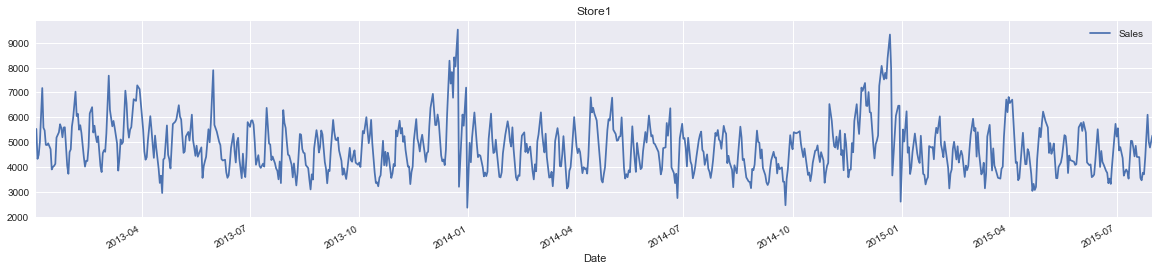

In [33]:
#分析门店1的销量随时间的变化
Store1 = data_train_store[data_train_store['Store']==1]
Store1.plot(x='Date',y='Sales',title='Store1',figsize=(20,4))

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


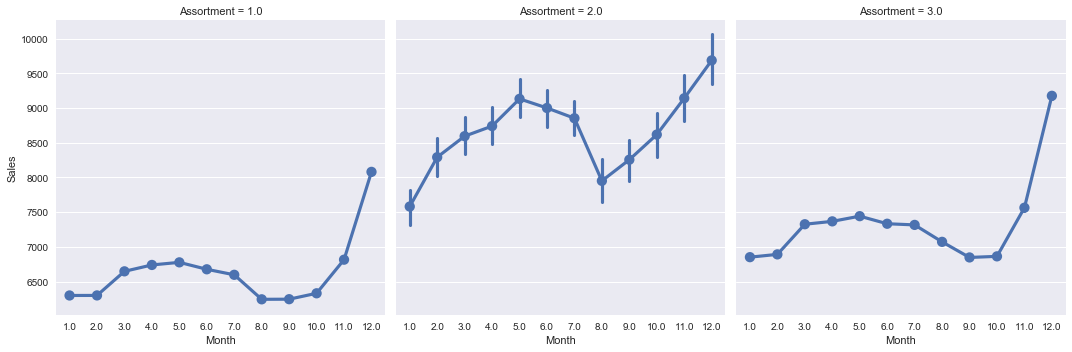

In [34]:
# 分析销量与Assortment的关系
sns.factorplot(data = data_train_store, x = 'Month', y = 'Sales',col='Assortment') 

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


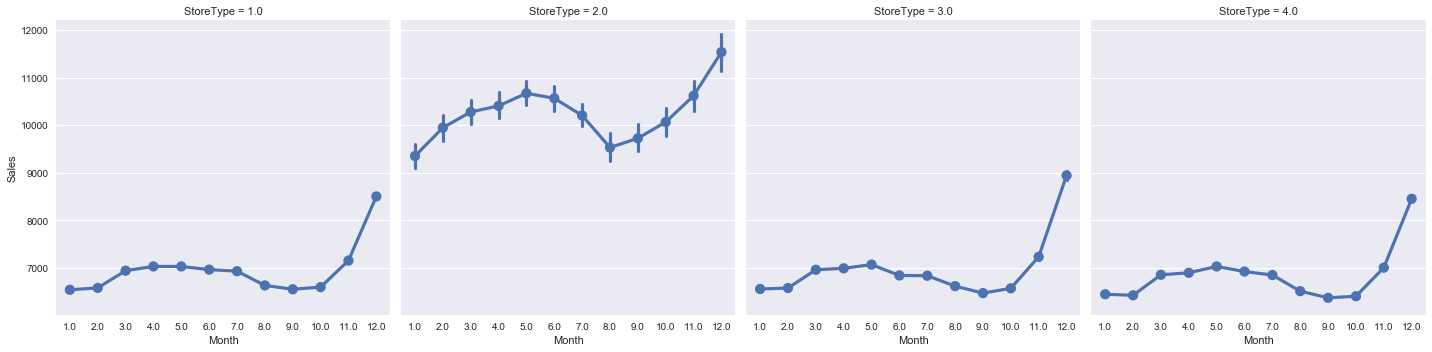

In [35]:
# 分析销量与StoreType的关系
sns.factorplot(data = data_train_store, x = 'Month', y = 'Sales',col='StoreType') 

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


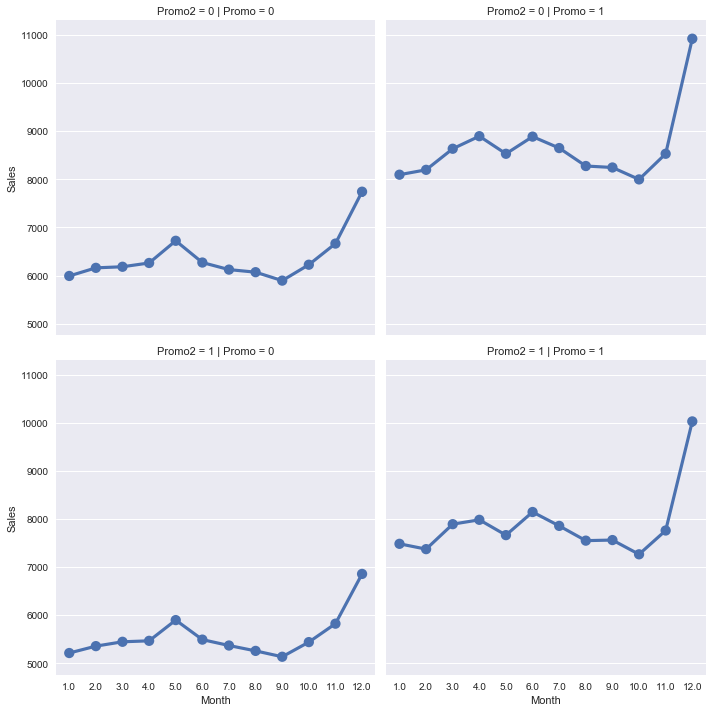

In [36]:
# 销量与促销活动的关系
sns.factorplot(data = data_train_store, x = 'Month', y = "Sales", col = 'Promo',row = 'Promo2')  

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


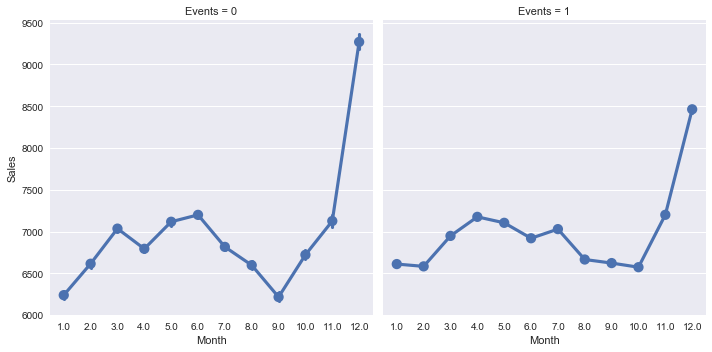

In [37]:
# 销量与天气的关系
sns.factorplot(data = data_train_store, x = 'Month', y = "Sales", col = 'Events')  

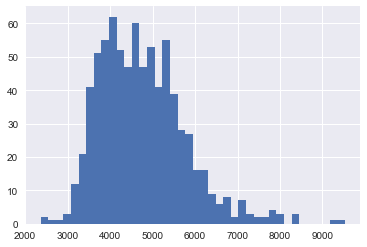

In [38]:
# 绘制门店1销量直方图
plt.hist(Store1['Sales'], bins=40)
plt.show()

In [39]:
#将不需要的特征删除  
data_train_store.drop(['Customers','Date','Open','PromoInterval','MonthStr','State','file','StateName'],axis = 1,inplace =True)
data_test_store.drop(['Id','Date','Open','PromoInterval','MonthStr','State','file','StateName'],axis = 1,inplace =True)
val_data.drop(['Customers','Date','Open','PromoInterval','MonthStr','State','file','StateName'],axis = 1,inplace =True)
train_data.drop(['Customers','Date','Open','PromoInterval','MonthStr','State','file','StateName'],axis = 1,inplace =True)

In [40]:
data_train_store.head()

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Events,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,InPromo
0,1,4.0,5263,1,0.0,1,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,1,2015.0,7.0,31.0,31.0,82.0,0.00,0
742,743,4.0,5085,1,0.0,1,1.0,1.0,6710.0,11.0,2003.0,1,14.0,2012.0,0,2015.0,7.0,31.0,31.0,140.0,40.25,1
748,749,4.0,6612,1,0.0,1,1.0,1.0,3410.0,8.0,2011.0,1,14.0,2015.0,0,2015.0,7.0,31.0,31.0,47.0,4.25,1
747,748,4.0,7481,1,0.0,1,4.0,1.0,2380.0,3.0,2010.0,1,14.0,2011.0,1,2015.0,7.0,31.0,31.0,64.0,52.25,1
746,747,4.0,10708,1,0.0,1,3.0,3.0,45740.0,8.0,2008.0,0,0.0,0.0,0,2015.0,7.0,31.0,31.0,83.0,0.00,0


In [41]:
data_test_store.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Events,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,InPromo
0,1,3.0,1,0.0,0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,1,2015.0,9.0,17.0,38.0,84.0,0.0,0
1,3,3.0,1,0.0,0,1.0,1.0,14130.0,12.0,2006.0,1,14.0,2011.0,1,2015.0,9.0,17.0,38.0,105.0,54.0,0
2,7,3.0,1,0.0,0,1.0,3.0,24000.0,4.0,2013.0,0,0.0,0.0,1,2015.0,9.0,17.0,38.0,29.0,0.0,0
3,8,3.0,1,0.0,0,1.0,1.0,7520.0,10.0,2014.0,0,0.0,0.0,1,2015.0,9.0,17.0,38.0,11.0,0.0,0
4,9,3.0,1,0.0,0,1.0,3.0,2030.0,8.0,2000.0,0,0.0,0.0,1,2015.0,9.0,17.0,38.0,181.0,0.0,0


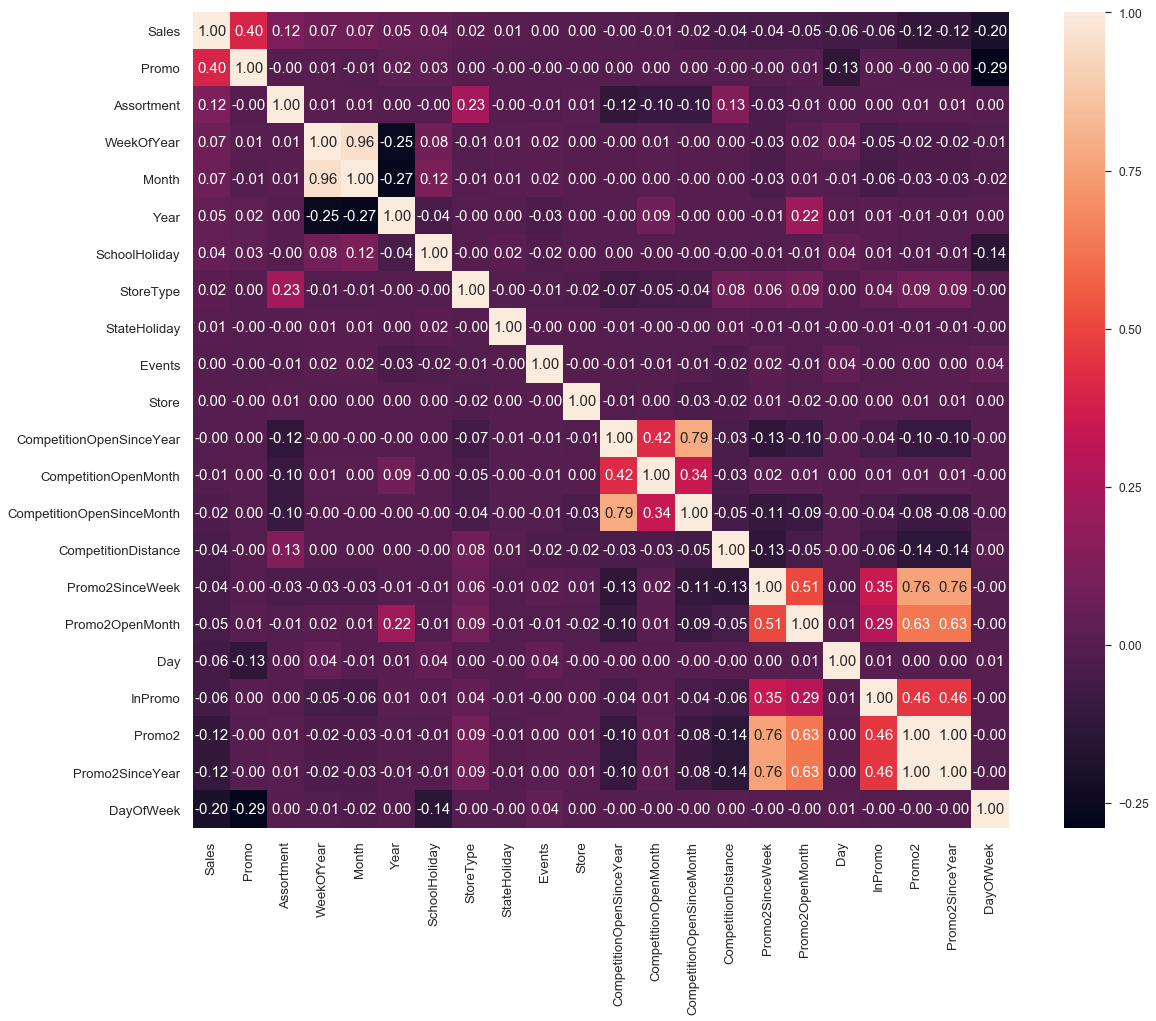

In [48]:
# 绘制Heatmap，可以用颜色变化来反映变量之间的相关性二维矩阵或说明相关性表格中的数据信息
corrmat = data_train_store.corr()
top_corr = corrmat.sort_values(by = ['Sales'], ascending = False).index
cm = np.corrcoef(data_train_store[top_corr].values.T)
f, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.1)
sns.heatmap(cm, cbar=True, annot=True,
                 square=True, fmt='.2f', annot_kws={'size': 15}, 
                 yticklabels=top_corr.values, xticklabels=top_corr.values)

In [43]:
# 对数据集使用log1p将标签数据从偏态分布转换为标准正态分布
data_train_store['Sales'] = np.log1p(data_train_store['Sales'])

#对val_data和train_data数据集做以上处理
val_data['Sales'] = np.log1p(val_data['Sales'])
train_data['Sales'] = np.log1p(train_data['Sales'])

## 建立模型

1、衡量标准：评估基于均方根百分比误差(RMSPE)

In [44]:
# For predict 
def rmspe(y, yhat):
    my = y != 0
    rmspe = np.sqrt(np.mean((1 - yhat/y) ** 2))
    return rmspe

# For XGBoost model
def xgb_rmspe(yhat,y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    rmspe = np.sqrt(np.mean((1 - yhat/y) ** 2))
    return 'rmspe',rmspe

# For lightgbm model
def lgb_rmspe(yhat,y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    rmspe = np.sqrt(np.mean((1 - yhat/y) ** 2))
    return 'rmspe',rmspe,False

2、数据分割

In [ ]:
# # 将`data_train_store`随机分割为训练集和交叉验证集
# label = data_train_store['Sales']
# features = data_train_store.drop(['Sales'],axis=1)
# X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.3, random_state=42)

In [45]:
# 将`data_train_store`按时间分割为训练集和交叉验证集, 划分最后六周作为验证集数据
train_data.sort_index(inplace = True)
val_data.sort_index(inplace = True)
X_train = train_data.drop(['Sales'],axis=1)
y_train = train_data['Sales']
X_val = val_data.drop(['Sales'],axis=1)
y_val = val_data['Sales']

3、构建模型

In [ ]:
def Ran_Forest_fit_model(X_train,X_val,y_train,y_val):
    model = RandomForestRegressor(n_estimators = 15)
    model.fit(X_train, y_train)
    
    # plot feature importance
    feat_importances = pd.Series(model.feature_importances_, index = X_train.columns)
    feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='bar')
    plt.xlabel('Importance')
    plt.title('Feature Importance')

    # validation
    y_predict = model.predict(X_val)
    result = rmspe(np.expm1(y_val), np.expm1(y_predict))
    print('RMSPE on validation data:{:.6f}'.format(result)) 
    return model

# Ran_Forest_fit_model(X_train,X_val,y_train,y_val)

In [ ]:
#  lightgbm模型
def lightgbm_fit_model(X_train,X_val,y_train,y_val):
    """ Using XGBoost model. """
    
    model = lgb.LGBMRegressor(objective = 'regression',
                              colsample_bytree=0.8,
                              max_depth = 10,
                              num_leaves = 10,
                              learning_rate = 0.01,
                              reg_alpha = 0.2, 
                              reg_lambda = 0.8,
                              subsample = 0.8,
                              n_estimators = 100000,
                              random_state = 20)
    
    model.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric=lgb_rmspe,early_stopping_rounds=50,verbose = True)

    print('画出特征重要度...')
    ax = lgb.plot_importance(model, max_num_features=10)
    plt.show()

    print('画出第9颗树...')
    ax = lgb.plot_tree(model, tree_index=8, figsize=(20, 8))
    plt.show()

    y_pred = model.predict(X_val)
    result = rmspe(np.expm1(y_val), np.expm1(y_pred))
    print('RMSPE on validation data:{:.6f}'.format(result))  
    return model

# lightgbm_fit_model(X_train,X_val,y_train,y_val)

In [107]:
# XGBoost模型1   learning_rat:0.03,max_depth:8
def XGBoost_fit_model_1(X_train,X_val,y_train,y_val):
    """ Using XGBoost model. """
    
    xgb_params = {'gamma':0.2,
                  'learning_rat': 0.03,
                  'max_depth':8,
                  'n_estimators': 5000,
                  'subsample': 0.8,
                  'colsample_bytree': 0.7,
                  'reg_lambda':0.8,
                  'reg_alpha': 0.2,
                  'objective': 'reg:squarederror',
                  'seed': 20}
   
    model = xgb.XGBRegressor(**xgb_params)
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_set = eval_set, eval_metric = xgb_rmspe, early_stopping_rounds = 100,verbose = True)  
    
    # plot feature importance
    print('画出特征重要度...')
    plot_importance(model)
    plt.show()
    
    #模型树可视化
    digraph = xgb.to_graphviz(model, num_trees=1)
    digraph.format = 'png'
    digraph.view('./model_xgb')
    
    y_pred = model.predict(X_val)
    result = rmspe(np.expm1(y_val), np.expm1(y_pred))
    print('RMSPE on validation data:{:.6f}'.format(result))
    
    return model

4、做出预测

[0]	validation_0-rmse:7.45009	validation_0-rmspe:0.999532
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.70984	validation_0-rmspe:0.998838
[2]	validation_0-rmse:6.04296	validation_0-rmspe:0.997584
[3]	validation_0-rmse:5.43934	validation_0-rmspe:0.995453
[4]	validation_0-rmse:4.89824	validation_0-rmspe:0.992083
[5]	validation_0-rmse:4.41222	validation_0-rmspe:0.987053
[6]	validation_0-rmse:3.97629	validation_0-rmspe:0.979923
[7]	validation_0-rmse:3.58411	validation_0-rmspe:0.970233
[8]	validation_0-rmse:3.22948	validation_0-rmspe:0.957557
[9]	validation_0-rmse:2.91227	validation_0-rmspe:0.941732
[10]	validation_0-rmse:2.62456	validation_0-rmspe:0.922348
[11]	validation_0-rmse:2.36741	validation_0-rmspe:0.899724
[12]	validation_0-rmse:2.13513	validation_0-rmspe:0.873702
[13]	validation_0-rmse:1.92712	validation_0-rmspe:0.844738
[14]	validation_0-rmse

[135]	validation_0-rmse:0.17072	validation_0-rmspe:0.184015
[136]	validation_0-rmse:0.169643	validation_0-rmspe:0.182859
[137]	validation_0-rmse:0.169439	validation_0-rmspe:0.182711
[138]	validation_0-rmse:0.168609	validation_0-rmspe:0.181837
[139]	validation_0-rmse:0.167813	validation_0-rmspe:0.180989
[140]	validation_0-rmse:0.166815	validation_0-rmspe:0.179876
[141]	validation_0-rmse:0.166522	validation_0-rmspe:0.179535
[142]	validation_0-rmse:0.166427	validation_0-rmspe:0.179573
[143]	validation_0-rmse:0.16601	validation_0-rmspe:0.17912
[144]	validation_0-rmse:0.164959	validation_0-rmspe:0.177971
[145]	validation_0-rmse:0.16464	validation_0-rmspe:0.177647
[146]	validation_0-rmse:0.164133	validation_0-rmspe:0.177057
[147]	validation_0-rmse:0.163454	validation_0-rmspe:0.176249
[148]	validation_0-rmse:0.163353	validation_0-rmspe:0.175963
[149]	validation_0-rmse:0.163122	validation_0-rmspe:0.175703
[150]	validation_0-rmse:0.162594	validation_0-rmspe:0.175177
[151]	validation_0-rmse:0.16

[270]	validation_0-rmse:0.135191	validation_0-rmspe:0.144566
[271]	validation_0-rmse:0.135102	validation_0-rmspe:0.144429
[272]	validation_0-rmse:0.134762	validation_0-rmspe:0.144002
[273]	validation_0-rmse:0.134525	validation_0-rmspe:0.143727
[274]	validation_0-rmse:0.134465	validation_0-rmspe:0.143677
[275]	validation_0-rmse:0.134413	validation_0-rmspe:0.143587
[276]	validation_0-rmse:0.134299	validation_0-rmspe:0.143521
[277]	validation_0-rmse:0.134255	validation_0-rmspe:0.143479
[278]	validation_0-rmse:0.134231	validation_0-rmspe:0.143453
[279]	validation_0-rmse:0.134116	validation_0-rmspe:0.143352
[280]	validation_0-rmse:0.134073	validation_0-rmspe:0.143308
[281]	validation_0-rmse:0.134049	validation_0-rmspe:0.143284
[282]	validation_0-rmse:0.134013	validation_0-rmspe:0.143255
[283]	validation_0-rmse:0.133931	validation_0-rmspe:0.143187
[284]	validation_0-rmse:0.133844	validation_0-rmspe:0.14322
[285]	validation_0-rmse:0.133721	validation_0-rmspe:0.143085
[286]	validation_0-rmse:0

[405]	validation_0-rmse:0.124999	validation_0-rmspe:0.132242
[406]	validation_0-rmse:0.12492	validation_0-rmspe:0.132169
[407]	validation_0-rmse:0.1249	validation_0-rmspe:0.132163
[408]	validation_0-rmse:0.124832	validation_0-rmspe:0.132095
[409]	validation_0-rmse:0.124813	validation_0-rmspe:0.132078
[410]	validation_0-rmse:0.124778	validation_0-rmspe:0.132051
[411]	validation_0-rmse:0.124774	validation_0-rmspe:0.132048
[412]	validation_0-rmse:0.124745	validation_0-rmspe:0.132027
[413]	validation_0-rmse:0.124707	validation_0-rmspe:0.131983
[414]	validation_0-rmse:0.124633	validation_0-rmspe:0.13191
[415]	validation_0-rmse:0.12448	validation_0-rmspe:0.131745
[416]	validation_0-rmse:0.124448	validation_0-rmspe:0.131715
[417]	validation_0-rmse:0.124323	validation_0-rmspe:0.131579
[418]	validation_0-rmse:0.124299	validation_0-rmspe:0.131544
[419]	validation_0-rmse:0.124249	validation_0-rmspe:0.131501
[420]	validation_0-rmse:0.124199	validation_0-rmspe:0.131422
[421]	validation_0-rmse:0.124

[540]	validation_0-rmse:0.121158	validation_0-rmspe:0.127892
[541]	validation_0-rmse:0.121158	validation_0-rmspe:0.127889
[542]	validation_0-rmse:0.121157	validation_0-rmspe:0.127884
[543]	validation_0-rmse:0.121122	validation_0-rmspe:0.127838
[544]	validation_0-rmse:0.121115	validation_0-rmspe:0.127832
[545]	validation_0-rmse:0.12107	validation_0-rmspe:0.127787
[546]	validation_0-rmse:0.121062	validation_0-rmspe:0.127782
[547]	validation_0-rmse:0.121029	validation_0-rmspe:0.127747
[548]	validation_0-rmse:0.121064	validation_0-rmspe:0.127787
[549]	validation_0-rmse:0.121065	validation_0-rmspe:0.127788
[550]	validation_0-rmse:0.120981	validation_0-rmspe:0.1277
[551]	validation_0-rmse:0.120972	validation_0-rmspe:0.127691
[552]	validation_0-rmse:0.120973	validation_0-rmspe:0.127694
[553]	validation_0-rmse:0.120958	validation_0-rmspe:0.127679
[554]	validation_0-rmse:0.12087	validation_0-rmspe:0.127604
[555]	validation_0-rmse:0.120781	validation_0-rmspe:0.127523
[556]	validation_0-rmse:0.12

[675]	validation_0-rmse:0.118721	validation_0-rmspe:0.124895
[676]	validation_0-rmse:0.118706	validation_0-rmspe:0.124897
[677]	validation_0-rmse:0.118705	validation_0-rmspe:0.124895
[678]	validation_0-rmse:0.118731	validation_0-rmspe:0.12494
[679]	validation_0-rmse:0.118724	validation_0-rmspe:0.124931
[680]	validation_0-rmse:0.11876	validation_0-rmspe:0.124964
[681]	validation_0-rmse:0.118768	validation_0-rmspe:0.124972
[682]	validation_0-rmse:0.118766	validation_0-rmspe:0.124967
[683]	validation_0-rmse:0.118741	validation_0-rmspe:0.124939
[684]	validation_0-rmse:0.118741	validation_0-rmspe:0.124934
[685]	validation_0-rmse:0.118741	validation_0-rmspe:0.124921
[686]	validation_0-rmse:0.118715	validation_0-rmspe:0.124889
[687]	validation_0-rmse:0.118712	validation_0-rmspe:0.124888
[688]	validation_0-rmse:0.118692	validation_0-rmspe:0.124853
[689]	validation_0-rmse:0.118703	validation_0-rmspe:0.124855
[690]	validation_0-rmse:0.11869	validation_0-rmspe:0.124843
[691]	validation_0-rmse:0.1

[810]	validation_0-rmse:0.117632	validation_0-rmspe:0.123636
[811]	validation_0-rmse:0.117624	validation_0-rmspe:0.12363
[812]	validation_0-rmse:0.117622	validation_0-rmspe:0.123634
[813]	validation_0-rmse:0.11755	validation_0-rmspe:0.123553
[814]	validation_0-rmse:0.117538	validation_0-rmspe:0.123552
[815]	validation_0-rmse:0.117521	validation_0-rmspe:0.123536
[816]	validation_0-rmse:0.117496	validation_0-rmspe:0.123516
[817]	validation_0-rmse:0.117482	validation_0-rmspe:0.123501
[818]	validation_0-rmse:0.117503	validation_0-rmspe:0.123544
[819]	validation_0-rmse:0.117492	validation_0-rmspe:0.12353
[820]	validation_0-rmse:0.117493	validation_0-rmspe:0.123533
[821]	validation_0-rmse:0.11749	validation_0-rmspe:0.12353
[822]	validation_0-rmse:0.117457	validation_0-rmspe:0.123501
[823]	validation_0-rmse:0.117459	validation_0-rmspe:0.123504
[824]	validation_0-rmse:0.117445	validation_0-rmspe:0.123486
[825]	validation_0-rmse:0.117434	validation_0-rmspe:0.123469
[826]	validation_0-rmse:0.117

[945]	validation_0-rmse:0.11677	validation_0-rmspe:0.122764
[946]	validation_0-rmse:0.11677	validation_0-rmspe:0.122765
[947]	validation_0-rmse:0.11677	validation_0-rmspe:0.122766
[948]	validation_0-rmse:0.116743	validation_0-rmspe:0.122735
[949]	validation_0-rmse:0.116729	validation_0-rmspe:0.12272
[950]	validation_0-rmse:0.116727	validation_0-rmspe:0.122718
[951]	validation_0-rmse:0.116728	validation_0-rmspe:0.122724
[952]	validation_0-rmse:0.116722	validation_0-rmspe:0.122718
[953]	validation_0-rmse:0.116716	validation_0-rmspe:0.12273
[954]	validation_0-rmse:0.116711	validation_0-rmspe:0.12272
[955]	validation_0-rmse:0.116706	validation_0-rmspe:0.122714
[956]	validation_0-rmse:0.116702	validation_0-rmspe:0.122712
[957]	validation_0-rmse:0.116702	validation_0-rmspe:0.122717
[958]	validation_0-rmse:0.1167	validation_0-rmspe:0.122712
[959]	validation_0-rmse:0.1167	validation_0-rmspe:0.122713
[960]	validation_0-rmse:0.116693	validation_0-rmspe:0.122703
[961]	validation_0-rmse:0.116691	v

[1079]	validation_0-rmse:0.116212	validation_0-rmspe:0.122138
[1080]	validation_0-rmse:0.116204	validation_0-rmspe:0.122128
[1081]	validation_0-rmse:0.116218	validation_0-rmspe:0.122166
[1082]	validation_0-rmse:0.116212	validation_0-rmspe:0.122159
[1083]	validation_0-rmse:0.116209	validation_0-rmspe:0.122154
[1084]	validation_0-rmse:0.116203	validation_0-rmspe:0.122152
[1085]	validation_0-rmse:0.116191	validation_0-rmspe:0.122134
[1086]	validation_0-rmse:0.116192	validation_0-rmspe:0.122138
[1087]	validation_0-rmse:0.116192	validation_0-rmspe:0.122136
[1088]	validation_0-rmse:0.116185	validation_0-rmspe:0.12213
[1089]	validation_0-rmse:0.116186	validation_0-rmspe:0.122133
[1090]	validation_0-rmse:0.116186	validation_0-rmspe:0.122135
[1091]	validation_0-rmse:0.116183	validation_0-rmspe:0.122133
[1092]	validation_0-rmse:0.116184	validation_0-rmspe:0.122133
[1093]	validation_0-rmse:0.116184	validation_0-rmspe:0.122137
[1094]	validation_0-rmse:0.116183	validation_0-rmspe:0.122135
[1095]	va

[1212]	validation_0-rmse:0.115557	validation_0-rmspe:0.121533
[1213]	validation_0-rmse:0.115554	validation_0-rmspe:0.121532
[1214]	validation_0-rmse:0.115536	validation_0-rmspe:0.12152
[1215]	validation_0-rmse:0.115536	validation_0-rmspe:0.121518
[1216]	validation_0-rmse:0.115536	validation_0-rmspe:0.121519
[1217]	validation_0-rmse:0.115521	validation_0-rmspe:0.121504
[1218]	validation_0-rmse:0.115521	validation_0-rmspe:0.121504
[1219]	validation_0-rmse:0.115521	validation_0-rmspe:0.121505
[1220]	validation_0-rmse:0.115523	validation_0-rmspe:0.121509
[1221]	validation_0-rmse:0.11552	validation_0-rmspe:0.121507
[1222]	validation_0-rmse:0.115521	validation_0-rmspe:0.121507
[1223]	validation_0-rmse:0.115516	validation_0-rmspe:0.121502
[1224]	validation_0-rmse:0.115517	validation_0-rmspe:0.121506
[1225]	validation_0-rmse:0.115515	validation_0-rmspe:0.121503
[1226]	validation_0-rmse:0.115515	validation_0-rmspe:0.121507
[1227]	validation_0-rmse:0.115515	validation_0-rmspe:0.121501
[1228]	val

[1345]	validation_0-rmse:0.11519	validation_0-rmspe:0.121023
[1346]	validation_0-rmse:0.115187	validation_0-rmspe:0.12102
[1347]	validation_0-rmse:0.115177	validation_0-rmspe:0.12101
[1348]	validation_0-rmse:0.115176	validation_0-rmspe:0.121009
[1349]	validation_0-rmse:0.115171	validation_0-rmspe:0.121001
[1350]	validation_0-rmse:0.115159	validation_0-rmspe:0.120987
[1351]	validation_0-rmse:0.115158	validation_0-rmspe:0.120982
[1352]	validation_0-rmse:0.115158	validation_0-rmspe:0.120982
[1353]	validation_0-rmse:0.115157	validation_0-rmspe:0.120981
[1354]	validation_0-rmse:0.115151	validation_0-rmspe:0.120973
[1355]	validation_0-rmse:0.115156	validation_0-rmspe:0.120979
[1356]	validation_0-rmse:0.115155	validation_0-rmspe:0.120978
[1357]	validation_0-rmse:0.115151	validation_0-rmspe:0.120977
[1358]	validation_0-rmse:0.115148	validation_0-rmspe:0.120977
[1359]	validation_0-rmse:0.115145	validation_0-rmspe:0.120974
[1360]	validation_0-rmse:0.115141	validation_0-rmspe:0.120936
[1361]	vali

[1478]	validation_0-rmse:0.114886	validation_0-rmspe:0.12071
[1479]	validation_0-rmse:0.114878	validation_0-rmspe:0.120704
[1480]	validation_0-rmse:0.114863	validation_0-rmspe:0.120679
[1481]	validation_0-rmse:0.114863	validation_0-rmspe:0.120675
[1482]	validation_0-rmse:0.114863	validation_0-rmspe:0.120677
[1483]	validation_0-rmse:0.114861	validation_0-rmspe:0.120674
[1484]	validation_0-rmse:0.114861	validation_0-rmspe:0.120674
[1485]	validation_0-rmse:0.114862	validation_0-rmspe:0.120676
[1486]	validation_0-rmse:0.114864	validation_0-rmspe:0.120676
[1487]	validation_0-rmse:0.114866	validation_0-rmspe:0.120678
[1488]	validation_0-rmse:0.114854	validation_0-rmspe:0.120668
[1489]	validation_0-rmse:0.114854	validation_0-rmspe:0.12067
[1490]	validation_0-rmse:0.114853	validation_0-rmspe:0.120667
[1491]	validation_0-rmse:0.114855	validation_0-rmspe:0.120671
[1492]	validation_0-rmse:0.114851	validation_0-rmspe:0.120669
[1493]	validation_0-rmse:0.114849	validation_0-rmspe:0.120666
[1494]	val

[1611]	validation_0-rmse:0.114616	validation_0-rmspe:0.120335
[1612]	validation_0-rmse:0.114616	validation_0-rmspe:0.120336
[1613]	validation_0-rmse:0.114617	validation_0-rmspe:0.120336
[1614]	validation_0-rmse:0.114617	validation_0-rmspe:0.120335
[1615]	validation_0-rmse:0.114616	validation_0-rmspe:0.120335
[1616]	validation_0-rmse:0.114615	validation_0-rmspe:0.120335
[1617]	validation_0-rmse:0.114605	validation_0-rmspe:0.12033
[1618]	validation_0-rmse:0.114604	validation_0-rmspe:0.120329
[1619]	validation_0-rmse:0.1146	validation_0-rmspe:0.120325
[1620]	validation_0-rmse:0.1146	validation_0-rmspe:0.120324
[1621]	validation_0-rmse:0.114601	validation_0-rmspe:0.120326
[1622]	validation_0-rmse:0.114599	validation_0-rmspe:0.120323
[1623]	validation_0-rmse:0.114593	validation_0-rmspe:0.120316
[1624]	validation_0-rmse:0.114595	validation_0-rmspe:0.120316
[1625]	validation_0-rmse:0.114594	validation_0-rmspe:0.120315
[1626]	validation_0-rmse:0.11461	validation_0-rmspe:0.120334
[1627]	validat

[1744]	validation_0-rmse:0.114568	validation_0-rmspe:0.12029
[1745]	validation_0-rmse:0.11457	validation_0-rmspe:0.120293
[1746]	validation_0-rmse:0.11457	validation_0-rmspe:0.120292
[1747]	validation_0-rmse:0.11457	validation_0-rmspe:0.120294
[1748]	validation_0-rmse:0.114567	validation_0-rmspe:0.120289
[1749]	validation_0-rmse:0.114567	validation_0-rmspe:0.120286
[1750]	validation_0-rmse:0.114564	validation_0-rmspe:0.120288
[1751]	validation_0-rmse:0.114566	validation_0-rmspe:0.12029
[1752]	validation_0-rmse:0.114564	validation_0-rmspe:0.120288
[1753]	validation_0-rmse:0.114554	validation_0-rmspe:0.120276
[1754]	validation_0-rmse:0.114546	validation_0-rmspe:0.120272
[1755]	validation_0-rmse:0.114541	validation_0-rmspe:0.120264
[1756]	validation_0-rmse:0.114536	validation_0-rmspe:0.120259
[1757]	validation_0-rmse:0.114538	validation_0-rmspe:0.120261
[1758]	validation_0-rmse:0.114525	validation_0-rmspe:0.120256
[1759]	validation_0-rmse:0.114525	validation_0-rmspe:0.120256
[1760]	valida

[1877]	validation_0-rmse:0.114285	validation_0-rmspe:0.12001
[1878]	validation_0-rmse:0.114286	validation_0-rmspe:0.120013
[1879]	validation_0-rmse:0.114284	validation_0-rmspe:0.12001
[1880]	validation_0-rmse:0.114284	validation_0-rmspe:0.12001
[1881]	validation_0-rmse:0.11428	validation_0-rmspe:0.120013
[1882]	validation_0-rmse:0.11428	validation_0-rmspe:0.120013
[1883]	validation_0-rmse:0.114279	validation_0-rmspe:0.120007
[1884]	validation_0-rmse:0.11428	validation_0-rmspe:0.120006
[1885]	validation_0-rmse:0.114272	validation_0-rmspe:0.119996
[1886]	validation_0-rmse:0.114273	validation_0-rmspe:0.119997
[1887]	validation_0-rmse:0.114272	validation_0-rmspe:0.119996
[1888]	validation_0-rmse:0.114273	validation_0-rmspe:0.119998
[1889]	validation_0-rmse:0.114273	validation_0-rmspe:0.119998
[1890]	validation_0-rmse:0.114267	validation_0-rmspe:0.119989
[1891]	validation_0-rmse:0.114267	validation_0-rmspe:0.11999
[1892]	validation_0-rmse:0.114265	validation_0-rmspe:0.119988
[1893]	validati

[2010]	validation_0-rmse:0.114156	validation_0-rmspe:0.119886
[2011]	validation_0-rmse:0.114156	validation_0-rmspe:0.119887
[2012]	validation_0-rmse:0.114153	validation_0-rmspe:0.119883
[2013]	validation_0-rmse:0.11415	validation_0-rmspe:0.119879
[2014]	validation_0-rmse:0.114151	validation_0-rmspe:0.11988
[2015]	validation_0-rmse:0.114148	validation_0-rmspe:0.119879
[2016]	validation_0-rmse:0.114145	validation_0-rmspe:0.119875
[2017]	validation_0-rmse:0.114145	validation_0-rmspe:0.119875
[2018]	validation_0-rmse:0.114145	validation_0-rmspe:0.119877
[2019]	validation_0-rmse:0.114145	validation_0-rmspe:0.119876
[2020]	validation_0-rmse:0.114145	validation_0-rmspe:0.119877
[2021]	validation_0-rmse:0.114145	validation_0-rmspe:0.119878
[2022]	validation_0-rmse:0.114145	validation_0-rmspe:0.119878
[2023]	validation_0-rmse:0.114142	validation_0-rmspe:0.119875
[2024]	validation_0-rmse:0.114139	validation_0-rmspe:0.11987
[2025]	validation_0-rmse:0.11414	validation_0-rmspe:0.119869
[2026]	valid

[2143]	validation_0-rmse:0.114016	validation_0-rmspe:0.119763
[2144]	validation_0-rmse:0.114015	validation_0-rmspe:0.11976
[2145]	validation_0-rmse:0.114014	validation_0-rmspe:0.119757
[2146]	validation_0-rmse:0.114015	validation_0-rmspe:0.119756
[2147]	validation_0-rmse:0.114014	validation_0-rmspe:0.119756
[2148]	validation_0-rmse:0.114014	validation_0-rmspe:0.119756
[2149]	validation_0-rmse:0.114022	validation_0-rmspe:0.119758
[2150]	validation_0-rmse:0.114021	validation_0-rmspe:0.119756
[2151]	validation_0-rmse:0.11402	validation_0-rmspe:0.119755
[2152]	validation_0-rmse:0.114017	validation_0-rmspe:0.119749
[2153]	validation_0-rmse:0.114017	validation_0-rmspe:0.119749
[2154]	validation_0-rmse:0.114011	validation_0-rmspe:0.119745
[2155]	validation_0-rmse:0.114011	validation_0-rmspe:0.119744
[2156]	validation_0-rmse:0.114011	validation_0-rmspe:0.119744
[2157]	validation_0-rmse:0.114028	validation_0-rmspe:0.119788
[2158]	validation_0-rmse:0.114028	validation_0-rmspe:0.119785
[2159]	val

[2276]	validation_0-rmse:0.11392	validation_0-rmspe:0.119649
[2277]	validation_0-rmse:0.113914	validation_0-rmspe:0.119646
[2278]	validation_0-rmse:0.113912	validation_0-rmspe:0.119643
[2279]	validation_0-rmse:0.113915	validation_0-rmspe:0.119649
[2280]	validation_0-rmse:0.113915	validation_0-rmspe:0.119651
[2281]	validation_0-rmse:0.113916	validation_0-rmspe:0.119652
[2282]	validation_0-rmse:0.113917	validation_0-rmspe:0.119653
[2283]	validation_0-rmse:0.113917	validation_0-rmspe:0.119653
[2284]	validation_0-rmse:0.113918	validation_0-rmspe:0.119653
[2285]	validation_0-rmse:0.113918	validation_0-rmspe:0.119653
[2286]	validation_0-rmse:0.113918	validation_0-rmspe:0.119653
[2287]	validation_0-rmse:0.113919	validation_0-rmspe:0.119654
[2288]	validation_0-rmse:0.113919	validation_0-rmspe:0.119654
[2289]	validation_0-rmse:0.113921	validation_0-rmspe:0.119656
[2290]	validation_0-rmse:0.113921	validation_0-rmspe:0.119656
[2291]	validation_0-rmse:0.11392	validation_0-rmspe:0.119655
[2292]	val

[2409]	validation_0-rmse:0.113847	validation_0-rmspe:0.119601
[2410]	validation_0-rmse:0.113846	validation_0-rmspe:0.119599
[2411]	validation_0-rmse:0.113846	validation_0-rmspe:0.119601
[2412]	validation_0-rmse:0.113843	validation_0-rmspe:0.1196
[2413]	validation_0-rmse:0.113843	validation_0-rmspe:0.119603
[2414]	validation_0-rmse:0.113844	validation_0-rmspe:0.119608
[2415]	validation_0-rmse:0.113844	validation_0-rmspe:0.119608
[2416]	validation_0-rmse:0.113842	validation_0-rmspe:0.119609
[2417]	validation_0-rmse:0.113842	validation_0-rmspe:0.11961
[2418]	validation_0-rmse:0.113842	validation_0-rmspe:0.119613
[2419]	validation_0-rmse:0.113842	validation_0-rmspe:0.119611
[2420]	validation_0-rmse:0.113841	validation_0-rmspe:0.119608
[2421]	validation_0-rmse:0.113829	validation_0-rmspe:0.119598
[2422]	validation_0-rmse:0.113829	validation_0-rmspe:0.119597
[2423]	validation_0-rmse:0.113817	validation_0-rmspe:0.119584
[2424]	validation_0-rmse:0.113818	validation_0-rmspe:0.119586
[2425]	vali

[2542]	validation_0-rmse:0.11369	validation_0-rmspe:0.119467
[2543]	validation_0-rmse:0.113691	validation_0-rmspe:0.119467
[2544]	validation_0-rmse:0.113692	validation_0-rmspe:0.119469
[2545]	validation_0-rmse:0.113691	validation_0-rmspe:0.119466
[2546]	validation_0-rmse:0.113689	validation_0-rmspe:0.119463
[2547]	validation_0-rmse:0.113689	validation_0-rmspe:0.119463
[2548]	validation_0-rmse:0.113679	validation_0-rmspe:0.119456
[2549]	validation_0-rmse:0.113677	validation_0-rmspe:0.119452
[2550]	validation_0-rmse:0.113678	validation_0-rmspe:0.119453
[2551]	validation_0-rmse:0.113678	validation_0-rmspe:0.119453
[2552]	validation_0-rmse:0.113677	validation_0-rmspe:0.119452
[2553]	validation_0-rmse:0.113677	validation_0-rmspe:0.119451
[2554]	validation_0-rmse:0.113677	validation_0-rmspe:0.119452
[2555]	validation_0-rmse:0.113677	validation_0-rmspe:0.119448
[2556]	validation_0-rmse:0.113673	validation_0-rmspe:0.119445
[2557]	validation_0-rmse:0.113673	validation_0-rmspe:0.119445
[2558]	va

[2675]	validation_0-rmse:0.113562	validation_0-rmspe:0.119329
[2676]	validation_0-rmse:0.113558	validation_0-rmspe:0.119326
[2677]	validation_0-rmse:0.113557	validation_0-rmspe:0.119325
[2678]	validation_0-rmse:0.113556	validation_0-rmspe:0.119326
[2679]	validation_0-rmse:0.113556	validation_0-rmspe:0.119327
[2680]	validation_0-rmse:0.113555	validation_0-rmspe:0.119328
[2681]	validation_0-rmse:0.113545	validation_0-rmspe:0.119315
[2682]	validation_0-rmse:0.113545	validation_0-rmspe:0.119314
[2683]	validation_0-rmse:0.113545	validation_0-rmspe:0.119314
[2684]	validation_0-rmse:0.113545	validation_0-rmspe:0.119309
[2685]	validation_0-rmse:0.113543	validation_0-rmspe:0.119307
[2686]	validation_0-rmse:0.113543	validation_0-rmspe:0.11931
[2687]	validation_0-rmse:0.113543	validation_0-rmspe:0.119311
[2688]	validation_0-rmse:0.113543	validation_0-rmspe:0.11931
[2689]	validation_0-rmse:0.113543	validation_0-rmspe:0.119312
[2690]	validation_0-rmse:0.113545	validation_0-rmspe:0.119314
[2691]	val

[2808]	validation_0-rmse:0.11347	validation_0-rmspe:0.119221
[2809]	validation_0-rmse:0.113471	validation_0-rmspe:0.119222
[2810]	validation_0-rmse:0.113467	validation_0-rmspe:0.119217
[2811]	validation_0-rmse:0.11336	validation_0-rmspe:0.119079
[2812]	validation_0-rmse:0.11336	validation_0-rmspe:0.11908
[2813]	validation_0-rmse:0.113357	validation_0-rmspe:0.119078
[2814]	validation_0-rmse:0.113359	validation_0-rmspe:0.11908
[2815]	validation_0-rmse:0.113356	validation_0-rmspe:0.119076
[2816]	validation_0-rmse:0.113357	validation_0-rmspe:0.119079
[2817]	validation_0-rmse:0.113357	validation_0-rmspe:0.119079
[2818]	validation_0-rmse:0.113355	validation_0-rmspe:0.119077
[2819]	validation_0-rmse:0.113355	validation_0-rmspe:0.119078
[2820]	validation_0-rmse:0.113355	validation_0-rmspe:0.119077
[2821]	validation_0-rmse:0.113355	validation_0-rmspe:0.119076
[2822]	validation_0-rmse:0.113355	validation_0-rmspe:0.119077
[2823]	validation_0-rmse:0.113348	validation_0-rmspe:0.119064
[2824]	valida

[2941]	validation_0-rmse:0.113247	validation_0-rmspe:0.11896
[2942]	validation_0-rmse:0.113247	validation_0-rmspe:0.118959
[2943]	validation_0-rmse:0.113246	validation_0-rmspe:0.11896
[2944]	validation_0-rmse:0.113246	validation_0-rmspe:0.11896
[2945]	validation_0-rmse:0.113246	validation_0-rmspe:0.11896
[2946]	validation_0-rmse:0.113246	validation_0-rmspe:0.118962
[2947]	validation_0-rmse:0.113245	validation_0-rmspe:0.118959
[2948]	validation_0-rmse:0.113244	validation_0-rmspe:0.118958
[2949]	validation_0-rmse:0.113244	validation_0-rmspe:0.118958
[2950]	validation_0-rmse:0.113243	validation_0-rmspe:0.118957
[2951]	validation_0-rmse:0.113243	validation_0-rmspe:0.118955
[2952]	validation_0-rmse:0.113243	validation_0-rmspe:0.118954
[2953]	validation_0-rmse:0.113243	validation_0-rmspe:0.118954
[2954]	validation_0-rmse:0.113244	validation_0-rmspe:0.118956
[2955]	validation_0-rmse:0.113244	validation_0-rmspe:0.118956
[2956]	validation_0-rmse:0.113244	validation_0-rmspe:0.118958
[2957]	valid

[3074]	validation_0-rmse:0.11327	validation_0-rmspe:0.119014
[3075]	validation_0-rmse:0.113272	validation_0-rmspe:0.119016
[3076]	validation_0-rmse:0.113268	validation_0-rmspe:0.119014
[3077]	validation_0-rmse:0.113268	validation_0-rmspe:0.119014
[3078]	validation_0-rmse:0.113267	validation_0-rmspe:0.119015
[3079]	validation_0-rmse:0.11327	validation_0-rmspe:0.119017
[3080]	validation_0-rmse:0.113269	validation_0-rmspe:0.119014
[3081]	validation_0-rmse:0.113269	validation_0-rmspe:0.119015
[3082]	validation_0-rmse:0.11327	validation_0-rmspe:0.119014
[3083]	validation_0-rmse:0.113268	validation_0-rmspe:0.119012
[3084]	validation_0-rmse:0.113266	validation_0-rmspe:0.11901
[3085]	validation_0-rmse:0.113265	validation_0-rmspe:0.119007
[3086]	validation_0-rmse:0.113265	validation_0-rmspe:0.119005
[3087]	validation_0-rmse:0.113265	validation_0-rmspe:0.119006
[3088]	validation_0-rmse:0.113289	validation_0-rmspe:0.119011
[3089]	validation_0-rmse:0.113303	validation_0-rmspe:0.119032
[3090]	valid

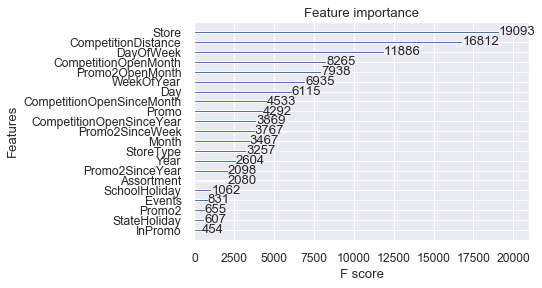

RMSPE on validation data:0.118931
success! 
 cost time: 2227.8984203338623 (s)


In [108]:
start_time = time.time()
model_1 = XGBoost_fit_model_1(X_train,X_val,y_train,y_val)

# 对测试集进行预测
y_proba_1 = model_1.predict(data_test_store)
cost_time = time.time()-start_time
print('success!','\n','cost time:',cost_time,'(s)')

# result_data = pd.DataFrame({'Id': data_test['Id'], 'Sales': np.expm1(y_proba_1)})
# result_data.to_csv('submission.csv', index=False)

5、校正优化

In [109]:
y_pred_1 = model_1.predict(X_val)
val_result = pd.DataFrame(data = expm1(y_val)
val_result['Prediction'] = expm1(y_pred_1)
val_result = pd.merge(X_val,val_result,left_index= True, right_index=True)
val_result['Error'] =abs(val_result.Prediction-val_result.Sales)
val_result['Weight'] = val_result.Prediction/val_result.Sales
val_result.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Events,Year,Month,Day,WeekOfYear,CompetitionOpenMonth,Promo2OpenMonth,InPromo,Sales,Prediction,Error,Weight
0,1,4.0,1,0.0,1,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,1,2015.0,7.0,31.0,31.0,82.0,0.00,0,8.568646,8.612626,0.043980,1.005133
1,2,4.0,1,0.0,1,1.0,1.0,570.0,11.0,2007.0,1,13.0,2010.0,1,2015.0,7.0,31.0,31.0,92.0,64.50,1,8.710290,8.643705,0.066584,0.992356
2,3,4.0,1,0.0,1,1.0,1.0,14130.0,12.0,2006.0,1,14.0,2011.0,1,2015.0,7.0,31.0,31.0,103.0,52.25,1,9.025816,9.136940,0.111124,1.012312
3,4,4.0,1,0.0,1,3.0,3.0,620.0,9.0,2009.0,0,0.0,0.0,0,2015.0,7.0,31.0,31.0,70.0,0.00,0,9.546527,9.282458,0.264069,0.972339
4,5,4.0,1,0.0,1,1.0,1.0,29910.0,4.0,2015.0,0,0.0,0.0,0,2015.0,7.0,31.0,31.0,3.0,0.00,0,8.481151,8.793382,0.312230,1.036815


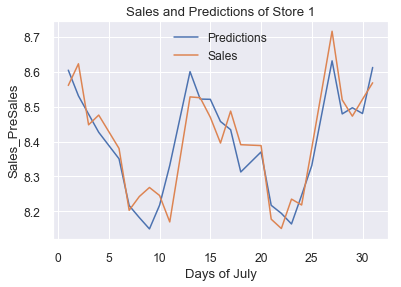

In [110]:
#以Store=1门店为例，检查预测结果
val_result.sort_values(by='Month',ascending=False,inplace=True)
num = sum(val_result['Month']==7)
val_result_7 = val_result.iloc[0:num,:].copy()
val_result_7.sort_values(by='Store',ascending=True,inplace=True)
num_1 = sum(val_result_7['Store']==1)
val_resultof1_7 = val_result_7.iloc[0:num_1,:].copy()
val_resultof1_7.sort_values(by='Day',ascending=True,inplace=True)

fig, ax = plt.subplots()
ax.plot(val_resultof1_7['Day'],val_resultof1_7['Prediction'], label='Predictions')
ax.plot(val_resultof1_7['Day'],val_resultof1_7['Sales'], label='Sales')

ax.set(ylabel='Sales_PreSales', xlabel='Days of July', title='Sales and Predictions of Store 1')
ax.legend()
plt.show()

No handles with labels found to put in legend.


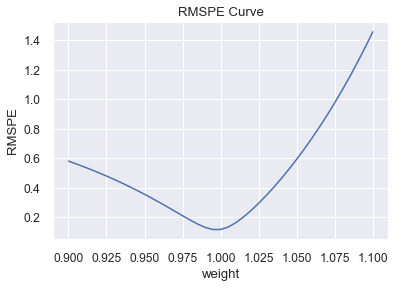

Best weight is 0.9950000000000001, RMSPE is 0.1185


In [111]:
weights = np.arange(0.9, 1.1, 0.005)
errors_1 = []
for w in weights:
    error_1 = rmspe(np.expm1(y_val), np.expm1(y_pred_1*w))
    errors_1.append(error_1)
    
fig, ax = plt.subplots()
ax.plot(weights,errors_1)
ax.set(ylabel='RMSPE', xlabel='weight', title='RMSPE Curve')
ax.legend()
plt.show()

idx = errors_1.index(min(errors_1))
weight_1 = weights[idx]
print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors_1)))

In [ ]:
# # make submission using best weight
# result_data = pd.DataFrame({'Id': data_test['Id'], 'Sales': np.expm1(y_proba*0.995)})
# result_data.to_csv('submission.csv', index=False)

6、模型融合

   为了得到更好的结果，我将用另两个参数不同的模型单独训练，接着进行偏差校正，最后将这三个模型进行进行融合。

In [101]:
# XGBoost模型2  learning_rat:0.03,max_depth:8,subsample:0.9，reg_alpha = 0,reg_lambda=1
def XGBoost_fit_model_2(X_train,X_val,y_train,y_val):
    """ Using XGBoost model. """
    
    xgb_params = {'gamma':0.2,
                  'learning_rat': 0.01,
                  'max_depth':8,
                  'n_estimators': 5000,
                  'subsample': 0.9,
                  'colsample_bytree': 0.7,
                  'objective': 'reg:squarederror',
                  'seed': 20}
   
    model = xgb.XGBRegressor(**xgb_params)
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_set = eval_set, eval_metric = xgb_rmspe, early_stopping_rounds = 100,verbose = True)  
    
    # plot feature importance
    print('画出特征重要度...')
    plot_importance(model)
    plt.show()
    
    #模型树可视化
    digraph = xgb.to_graphviz(model, num_trees=1)
    digraph.format = 'png'
    digraph.view('./model_xgb')
    
    y_pred = model.predict(X_val)
    result = rmspe(np.expm1(y_val), np.expm1(y_pred))
    print('RMSPE on validation data:{:.6f}'.format(result))
    
    return model

[0]	validation_0-rmse:7.45013	validation_0-rmspe:0.999532
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.71026	validation_0-rmspe:0.998838
[2]	validation_0-rmse:6.0434	validation_0-rmspe:0.997585
[3]	validation_0-rmse:5.43977	validation_0-rmspe:0.995454
[4]	validation_0-rmse:4.89876	validation_0-rmspe:0.992087
[5]	validation_0-rmse:4.4131	validation_0-rmspe:0.987062
[6]	validation_0-rmse:3.97721	validation_0-rmspe:0.979938
[7]	validation_0-rmse:3.58436	validation_0-rmspe:0.970247
[8]	validation_0-rmse:3.23034	validation_0-rmspe:0.957602
[9]	validation_0-rmse:2.91313	validation_0-rmspe:0.94178
[10]	validation_0-rmse:2.62679	validation_0-rmspe:0.922517
[11]	validation_0-rmse:2.3699	validation_0-rmspe:0.899962
[12]	validation_0-rmse:2.13761	validation_0-rmspe:0.874002
[13]	validation_0-rmse:1.92974	validation_0-rmspe:0.845136
[14]	validation_0-rmse:1.7

[135]	validation_0-rmse:0.171221	validation_0-rmspe:0.184349
[136]	validation_0-rmse:0.170394	validation_0-rmspe:0.183517
[137]	validation_0-rmse:0.16974	validation_0-rmspe:0.182665
[138]	validation_0-rmse:0.169597	validation_0-rmspe:0.182538
[139]	validation_0-rmse:0.169051	validation_0-rmspe:0.181895
[140]	validation_0-rmse:0.168468	validation_0-rmspe:0.181382
[141]	validation_0-rmse:0.168145	validation_0-rmspe:0.180997
[142]	validation_0-rmse:0.167573	validation_0-rmspe:0.180433
[143]	validation_0-rmse:0.167828	validation_0-rmspe:0.18038
[144]	validation_0-rmse:0.166983	validation_0-rmspe:0.179429
[145]	validation_0-rmse:0.16646	validation_0-rmspe:0.178834
[146]	validation_0-rmse:0.165798	validation_0-rmspe:0.178094
[147]	validation_0-rmse:0.16502	validation_0-rmspe:0.177436
[148]	validation_0-rmse:0.1649	validation_0-rmspe:0.177553
[149]	validation_0-rmse:0.164399	validation_0-rmspe:0.176964
[150]	validation_0-rmse:0.164165	validation_0-rmspe:0.176723
[151]	validation_0-rmse:0.1636

[271]	validation_0-rmse:0.136479	validation_0-rmspe:0.146694
[272]	validation_0-rmse:0.136344	validation_0-rmspe:0.146519
[273]	validation_0-rmse:0.136114	validation_0-rmspe:0.146231
[274]	validation_0-rmse:0.136006	validation_0-rmspe:0.146113
[275]	validation_0-rmse:0.135791	validation_0-rmspe:0.14587
[276]	validation_0-rmse:0.135691	validation_0-rmspe:0.145821
[277]	validation_0-rmse:0.135599	validation_0-rmspe:0.145693
[278]	validation_0-rmse:0.135525	validation_0-rmspe:0.145627
[279]	validation_0-rmse:0.135437	validation_0-rmspe:0.145538
[280]	validation_0-rmse:0.13538	validation_0-rmspe:0.145473
[281]	validation_0-rmse:0.135175	validation_0-rmspe:0.145236
[282]	validation_0-rmse:0.135088	validation_0-rmspe:0.145041
[283]	validation_0-rmse:0.13501	validation_0-rmspe:0.144947
[284]	validation_0-rmse:0.134827	validation_0-rmspe:0.144733
[285]	validation_0-rmse:0.13479	validation_0-rmspe:0.144697
[286]	validation_0-rmse:0.134489	validation_0-rmspe:0.144324
[287]	validation_0-rmse:0.13

[406]	validation_0-rmse:0.127476	validation_0-rmspe:0.136433
[407]	validation_0-rmse:0.127461	validation_0-rmspe:0.136414
[408]	validation_0-rmse:0.127458	validation_0-rmspe:0.136413
[409]	validation_0-rmse:0.127445	validation_0-rmspe:0.136399
[410]	validation_0-rmse:0.127421	validation_0-rmspe:0.136379
[411]	validation_0-rmse:0.12743	validation_0-rmspe:0.136403
[412]	validation_0-rmse:0.12734	validation_0-rmspe:0.136219
[413]	validation_0-rmse:0.127282	validation_0-rmspe:0.136185
[414]	validation_0-rmse:0.127204	validation_0-rmspe:0.136101
[415]	validation_0-rmse:0.127132	validation_0-rmspe:0.136014
[416]	validation_0-rmse:0.127121	validation_0-rmspe:0.136001
[417]	validation_0-rmse:0.127084	validation_0-rmspe:0.135945
[418]	validation_0-rmse:0.127067	validation_0-rmspe:0.135927
[419]	validation_0-rmse:0.127062	validation_0-rmspe:0.135863
[420]	validation_0-rmse:0.126956	validation_0-rmspe:0.135746
[421]	validation_0-rmse:0.126946	validation_0-rmspe:0.135737
[422]	validation_0-rmse:0.

[541]	validation_0-rmse:0.122634	validation_0-rmspe:0.130521
[542]	validation_0-rmse:0.12259	validation_0-rmspe:0.130471
[543]	validation_0-rmse:0.122532	validation_0-rmspe:0.130399
[544]	validation_0-rmse:0.12253	validation_0-rmspe:0.130404
[545]	validation_0-rmse:0.122433	validation_0-rmspe:0.130299
[546]	validation_0-rmse:0.122421	validation_0-rmspe:0.130297
[547]	validation_0-rmse:0.122391	validation_0-rmspe:0.13028
[548]	validation_0-rmse:0.12238	validation_0-rmspe:0.13026
[549]	validation_0-rmse:0.122356	validation_0-rmspe:0.130235
[550]	validation_0-rmse:0.122312	validation_0-rmspe:0.13018
[551]	validation_0-rmse:0.122242	validation_0-rmspe:0.130102
[552]	validation_0-rmse:0.122198	validation_0-rmspe:0.130064
[553]	validation_0-rmse:0.122195	validation_0-rmspe:0.130057
[554]	validation_0-rmse:0.122226	validation_0-rmspe:0.130085
[555]	validation_0-rmse:0.122219	validation_0-rmspe:0.130078
[556]	validation_0-rmse:0.122162	validation_0-rmspe:0.130026
[557]	validation_0-rmse:0.1221

[676]	validation_0-rmse:0.120395	validation_0-rmspe:0.1276
[677]	validation_0-rmse:0.120386	validation_0-rmspe:0.127592
[678]	validation_0-rmse:0.120407	validation_0-rmspe:0.12761
[679]	validation_0-rmse:0.120408	validation_0-rmspe:0.127612
[680]	validation_0-rmse:0.120407	validation_0-rmspe:0.127613
[681]	validation_0-rmse:0.120404	validation_0-rmspe:0.127616
[682]	validation_0-rmse:0.120404	validation_0-rmspe:0.127615
[683]	validation_0-rmse:0.120394	validation_0-rmspe:0.127607
[684]	validation_0-rmse:0.120394	validation_0-rmspe:0.127606
[685]	validation_0-rmse:0.120395	validation_0-rmspe:0.127608
[686]	validation_0-rmse:0.120379	validation_0-rmspe:0.127593
[687]	validation_0-rmse:0.120378	validation_0-rmspe:0.12759
[688]	validation_0-rmse:0.120375	validation_0-rmspe:0.127579
[689]	validation_0-rmse:0.120376	validation_0-rmspe:0.127581
[690]	validation_0-rmse:0.120347	validation_0-rmspe:0.127548
[691]	validation_0-rmse:0.120345	validation_0-rmspe:0.127551
[692]	validation_0-rmse:0.12

[811]	validation_0-rmse:0.119411	validation_0-rmspe:0.126617
[812]	validation_0-rmse:0.119397	validation_0-rmspe:0.126607
[813]	validation_0-rmse:0.119395	validation_0-rmspe:0.126607
[814]	validation_0-rmse:0.119351	validation_0-rmspe:0.126557
[815]	validation_0-rmse:0.119321	validation_0-rmspe:0.126531
[816]	validation_0-rmse:0.119312	validation_0-rmspe:0.126523
[817]	validation_0-rmse:0.119308	validation_0-rmspe:0.126516
[818]	validation_0-rmse:0.119293	validation_0-rmspe:0.126455
[819]	validation_0-rmse:0.119294	validation_0-rmspe:0.12646
[820]	validation_0-rmse:0.119292	validation_0-rmspe:0.126461
[821]	validation_0-rmse:0.119292	validation_0-rmspe:0.126462
[822]	validation_0-rmse:0.119283	validation_0-rmspe:0.126457
[823]	validation_0-rmse:0.119277	validation_0-rmspe:0.126446
[824]	validation_0-rmse:0.119307	validation_0-rmspe:0.126497
[825]	validation_0-rmse:0.119302	validation_0-rmspe:0.126482
[826]	validation_0-rmse:0.119297	validation_0-rmspe:0.126486
[827]	validation_0-rmse:0

[946]	validation_0-rmse:0.118566	validation_0-rmspe:0.125661
[947]	validation_0-rmse:0.118542	validation_0-rmspe:0.125648
[948]	validation_0-rmse:0.118531	validation_0-rmspe:0.125634
[949]	validation_0-rmse:0.118526	validation_0-rmspe:0.12563
[950]	validation_0-rmse:0.118525	validation_0-rmspe:0.125631
[951]	validation_0-rmse:0.118525	validation_0-rmspe:0.125631
[952]	validation_0-rmse:0.118519	validation_0-rmspe:0.125623
[953]	validation_0-rmse:0.118519	validation_0-rmspe:0.125622
[954]	validation_0-rmse:0.118519	validation_0-rmspe:0.125625
[955]	validation_0-rmse:0.118521	validation_0-rmspe:0.125629
[956]	validation_0-rmse:0.118507	validation_0-rmspe:0.125618
[957]	validation_0-rmse:0.118509	validation_0-rmspe:0.125626
[958]	validation_0-rmse:0.118529	validation_0-rmspe:0.125644
[959]	validation_0-rmse:0.11853	validation_0-rmspe:0.125646
[960]	validation_0-rmse:0.11853	validation_0-rmspe:0.125646
[961]	validation_0-rmse:0.118528	validation_0-rmspe:0.125645
[962]	validation_0-rmse:0.1

[1080]	validation_0-rmse:0.117977	validation_0-rmspe:0.125069
[1081]	validation_0-rmse:0.117971	validation_0-rmspe:0.125068
[1082]	validation_0-rmse:0.117949	validation_0-rmspe:0.125044
[1083]	validation_0-rmse:0.117943	validation_0-rmspe:0.125037
[1084]	validation_0-rmse:0.117925	validation_0-rmspe:0.125017
[1085]	validation_0-rmse:0.117927	validation_0-rmspe:0.125017
[1086]	validation_0-rmse:0.117927	validation_0-rmspe:0.125017
[1087]	validation_0-rmse:0.11792	validation_0-rmspe:0.125012
[1088]	validation_0-rmse:0.11792	validation_0-rmspe:0.125013
[1089]	validation_0-rmse:0.117893	validation_0-rmspe:0.124982
[1090]	validation_0-rmse:0.117886	validation_0-rmspe:0.124973
[1091]	validation_0-rmse:0.117887	validation_0-rmspe:0.124974
[1092]	validation_0-rmse:0.117885	validation_0-rmspe:0.124971
[1093]	validation_0-rmse:0.117885	validation_0-rmspe:0.124971
[1094]	validation_0-rmse:0.117876	validation_0-rmspe:0.124962
[1095]	validation_0-rmse:0.117876	validation_0-rmspe:0.124963
[1096]	val

[1213]	validation_0-rmse:0.117666	validation_0-rmspe:0.124593
[1214]	validation_0-rmse:0.117653	validation_0-rmspe:0.124581
[1215]	validation_0-rmse:0.117655	validation_0-rmspe:0.124584
[1216]	validation_0-rmse:0.117655	validation_0-rmspe:0.124585
[1217]	validation_0-rmse:0.117655	validation_0-rmspe:0.124584
[1218]	validation_0-rmse:0.117653	validation_0-rmspe:0.124583
[1219]	validation_0-rmse:0.117652	validation_0-rmspe:0.124583
[1220]	validation_0-rmse:0.11765	validation_0-rmspe:0.124583
[1221]	validation_0-rmse:0.11765	validation_0-rmspe:0.124584
[1222]	validation_0-rmse:0.11765	validation_0-rmspe:0.124579
[1223]	validation_0-rmse:0.117646	validation_0-rmspe:0.124576
[1224]	validation_0-rmse:0.117647	validation_0-rmspe:0.124577
[1225]	validation_0-rmse:0.117644	validation_0-rmspe:0.124573
[1226]	validation_0-rmse:0.117628	validation_0-rmspe:0.12455
[1227]	validation_0-rmse:0.117628	validation_0-rmspe:0.124549
[1228]	validation_0-rmse:0.117628	validation_0-rmspe:0.124549
[1229]	valid

[1346]	validation_0-rmse:0.117365	validation_0-rmspe:0.124219
[1347]	validation_0-rmse:0.117361	validation_0-rmspe:0.124216
[1348]	validation_0-rmse:0.117361	validation_0-rmspe:0.124216
[1349]	validation_0-rmse:0.117361	validation_0-rmspe:0.124218
[1350]	validation_0-rmse:0.117359	validation_0-rmspe:0.124215
[1351]	validation_0-rmse:0.117352	validation_0-rmspe:0.1242
[1352]	validation_0-rmse:0.117347	validation_0-rmspe:0.124196
[1353]	validation_0-rmse:0.11736	validation_0-rmspe:0.124197
[1354]	validation_0-rmse:0.117354	validation_0-rmspe:0.124192
[1355]	validation_0-rmse:0.117354	validation_0-rmspe:0.124191
[1356]	validation_0-rmse:0.117352	validation_0-rmspe:0.124188
[1357]	validation_0-rmse:0.117352	validation_0-rmspe:0.124188
[1358]	validation_0-rmse:0.117352	validation_0-rmspe:0.12419
[1359]	validation_0-rmse:0.117351	validation_0-rmspe:0.124189
[1360]	validation_0-rmse:0.11735	validation_0-rmspe:0.124188
[1361]	validation_0-rmse:0.117357	validation_0-rmspe:0.1242
[1362]	validati

[1479]	validation_0-rmse:0.117114	validation_0-rmspe:0.124005
[1480]	validation_0-rmse:0.117114	validation_0-rmspe:0.124004
[1481]	validation_0-rmse:0.11713	validation_0-rmspe:0.12404
[1482]	validation_0-rmse:0.117127	validation_0-rmspe:0.124039
[1483]	validation_0-rmse:0.117123	validation_0-rmspe:0.124036
[1484]	validation_0-rmse:0.117122	validation_0-rmspe:0.124036
[1485]	validation_0-rmse:0.117122	validation_0-rmspe:0.124034
[1486]	validation_0-rmse:0.117171	validation_0-rmspe:0.124078
[1487]	validation_0-rmse:0.117171	validation_0-rmspe:0.124081
[1488]	validation_0-rmse:0.117132	validation_0-rmspe:0.12405
[1489]	validation_0-rmse:0.117131	validation_0-rmspe:0.124053
[1490]	validation_0-rmse:0.117127	validation_0-rmspe:0.124042
[1491]	validation_0-rmse:0.117126	validation_0-rmspe:0.124039
[1492]	validation_0-rmse:0.117126	validation_0-rmspe:0.12404
[1493]	validation_0-rmse:0.117126	validation_0-rmspe:0.12404
[1494]	validation_0-rmse:0.117126	validation_0-rmspe:0.124041
[1495]	valida

[1612]	validation_0-rmse:0.116985	validation_0-rmspe:0.12373
[1613]	validation_0-rmse:0.116974	validation_0-rmspe:0.123715
[1614]	validation_0-rmse:0.116982	validation_0-rmspe:0.12372
[1615]	validation_0-rmse:0.116974	validation_0-rmspe:0.12371
[1616]	validation_0-rmse:0.116971	validation_0-rmspe:0.123707
[1617]	validation_0-rmse:0.116962	validation_0-rmspe:0.123699
[1618]	validation_0-rmse:0.116961	validation_0-rmspe:0.123693
[1619]	validation_0-rmse:0.116957	validation_0-rmspe:0.123688
[1620]	validation_0-rmse:0.116958	validation_0-rmspe:0.123689
[1621]	validation_0-rmse:0.116958	validation_0-rmspe:0.12369
[1622]	validation_0-rmse:0.116954	validation_0-rmspe:0.123687
[1623]	validation_0-rmse:0.116952	validation_0-rmspe:0.123685
[1624]	validation_0-rmse:0.116952	validation_0-rmspe:0.123686
[1625]	validation_0-rmse:0.116952	validation_0-rmspe:0.123686
[1626]	validation_0-rmse:0.116951	validation_0-rmspe:0.123679
[1627]	validation_0-rmse:0.116946	validation_0-rmspe:0.123683
[1628]	valid

[1745]	validation_0-rmse:0.116901	validation_0-rmspe:0.123662
[1746]	validation_0-rmse:0.1169	validation_0-rmspe:0.123659
[1747]	validation_0-rmse:0.1169	validation_0-rmspe:0.123659
[1748]	validation_0-rmse:0.1169	validation_0-rmspe:0.123658
[1749]	validation_0-rmse:0.116896	validation_0-rmspe:0.123653
[1750]	validation_0-rmse:0.116895	validation_0-rmspe:0.12365
[1751]	validation_0-rmse:0.116896	validation_0-rmspe:0.123651
[1752]	validation_0-rmse:0.116896	validation_0-rmspe:0.123654
[1753]	validation_0-rmse:0.116897	validation_0-rmspe:0.123653
[1754]	validation_0-rmse:0.116897	validation_0-rmspe:0.123654
[1755]	validation_0-rmse:0.116894	validation_0-rmspe:0.123649
[1756]	validation_0-rmse:0.116894	validation_0-rmspe:0.123648
[1757]	validation_0-rmse:0.116894	validation_0-rmspe:0.123648
[1758]	validation_0-rmse:0.116896	validation_0-rmspe:0.123652
[1759]	validation_0-rmse:0.116893	validation_0-rmspe:0.123654
[1760]	validation_0-rmse:0.116886	validation_0-rmspe:0.123643
[1761]	validati

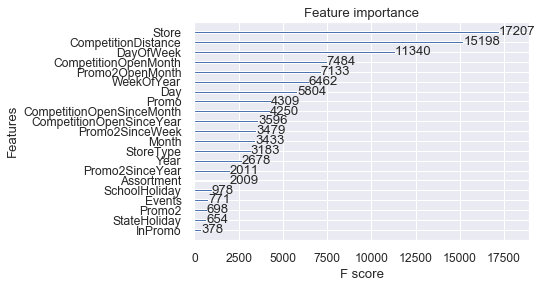

RMSPE on validation data:0.123626
success! 
 cost time: 1206.1307249069214 (s)


In [102]:
start_time = time.time()
model_2 = XGBoost_fit_model_2(X_train,X_val,y_train,y_val)

# 对验证集进行预测
y_pred_2 = model_2.predict(X_val)

# 对测试集进行预测
y_proba_2 = model_2.predict(data_test_store)
cost_time = time.time()-start_time
print('success!','\n','cost time:',cost_time,'(s)')

No handles with labels found to put in legend.


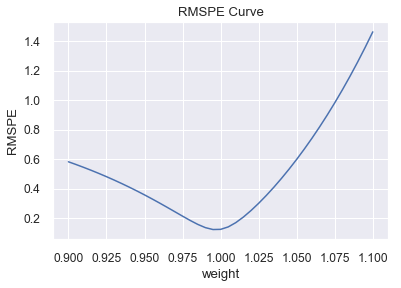

Best weight is 0.9950000000000001, RMSPE is 0.1225


In [112]:
# weights = np.arange(0.9, 1.1, 0.005)
errors_2 = []
for w in weights:
    error_2 = rmspe(np.expm1(y_val), np.expm1(y_pred_2*w))
    errors_2.append(error_2)
    
fig, ax = plt.subplots()
ax.plot(weights,errors_2)
ax.set(ylabel='RMSPE', xlabel='weight', title='RMSPE Curve')
ax.legend()
plt.show()

idx = errors_2.index(min(errors_2))
weight_2 = weights[idx]
print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors_2)))

In [104]:
# XGBoost模型3  learning_rat:0.01,max_depth:10
def XGBoost_fit_model_3(X_train,X_val,y_train,y_val):
    """ Using XGBoost model. """
    
    xgb_params = {'gamma':0.2,
                  'learning_rat': 0.01,
                  'max_depth':10,
                  'n_estimators': 5000,
                  'subsample': 0.8,
                  'colsample_bytree': 0.7,
                  'objective': 'reg:squarederror',
                  'seed': 20}
   
    model = xgb.XGBRegressor(**xgb_params)
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_set = eval_set, eval_metric = xgb_rmspe, early_stopping_rounds = 100,verbose = True)  
    
    # plot feature importance
    print('画出特征重要度...')
    plot_importance(model)
    plt.show()
    
    #模型树可视化
    digraph = xgb.to_graphviz(model, num_trees=1)
    digraph.format = 'png'
    digraph.view('./model_xgb')
    
    y_pred = model.predict(X_val)
    result = rmspe(np.expm1(y_val), np.expm1(y_pred))
    print('RMSPE on validation data:{:.6f}'.format(result))
    
    return model

[0]	validation_0-rmse:7.45012	validation_0-rmspe:0.999533
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.70979	validation_0-rmspe:0.99884
[2]	validation_0-rmse:6.0427	validation_0-rmspe:0.99759
[3]	validation_0-rmse:5.43886	validation_0-rmspe:0.995465
[4]	validation_0-rmse:4.89761	validation_0-rmspe:0.99211
[5]	validation_0-rmse:4.41136	validation_0-rmspe:0.987096
[6]	validation_0-rmse:3.97516	validation_0-rmspe:0.980005
[7]	validation_0-rmse:3.58114	validation_0-rmspe:0.970345
[8]	validation_0-rmse:3.22593	validation_0-rmspe:0.957699
[9]	validation_0-rmse:2.90822	validation_0-rmspe:0.941891
[10]	validation_0-rmse:2.61834	validation_0-rmspe:0.922422
[11]	validation_0-rmse:2.36103	validation_0-rmspe:0.899789
[12]	validation_0-rmse:2.12893	validation_0-rmspe:0.87384
[13]	validation_0-rmse:1.92044	validation_0-rmspe:0.84498
[14]	validation_0-rmse:1.733

[135]	validation_0-rmse:0.141867	validation_0-rmspe:0.150212
[136]	validation_0-rmse:0.141444	validation_0-rmspe:0.14976
[137]	validation_0-rmse:0.141139	validation_0-rmspe:0.149374
[138]	validation_0-rmse:0.141055	validation_0-rmspe:0.149268
[139]	validation_0-rmse:0.140638	validation_0-rmspe:0.148825
[140]	validation_0-rmse:0.140318	validation_0-rmspe:0.148412
[141]	validation_0-rmse:0.140185	validation_0-rmspe:0.148284
[142]	validation_0-rmse:0.139877	validation_0-rmspe:0.147918
[143]	validation_0-rmse:0.139446	validation_0-rmspe:0.147467
[144]	validation_0-rmse:0.1394	validation_0-rmspe:0.147432
[145]	validation_0-rmse:0.139026	validation_0-rmspe:0.147061
[146]	validation_0-rmse:0.138677	validation_0-rmspe:0.146702
[147]	validation_0-rmse:0.138553	validation_0-rmspe:0.146607
[148]	validation_0-rmse:0.138324	validation_0-rmspe:0.146345
[149]	validation_0-rmse:0.138193	validation_0-rmspe:0.146192
[150]	validation_0-rmse:0.13805	validation_0-rmspe:0.146021
[151]	validation_0-rmse:0.13

[270]	validation_0-rmse:0.124039	validation_0-rmspe:0.130015
[271]	validation_0-rmse:0.124001	validation_0-rmspe:0.129968
[272]	validation_0-rmse:0.123925	validation_0-rmspe:0.129892
[273]	validation_0-rmse:0.123871	validation_0-rmspe:0.129844
[274]	validation_0-rmse:0.123741	validation_0-rmspe:0.129769
[275]	validation_0-rmse:0.123691	validation_0-rmspe:0.129729
[276]	validation_0-rmse:0.123609	validation_0-rmspe:0.129655
[277]	validation_0-rmse:0.123581	validation_0-rmspe:0.129622
[278]	validation_0-rmse:0.123564	validation_0-rmspe:0.129612
[279]	validation_0-rmse:0.123515	validation_0-rmspe:0.129542
[280]	validation_0-rmse:0.123485	validation_0-rmspe:0.129505
[281]	validation_0-rmse:0.123419	validation_0-rmspe:0.129426
[282]	validation_0-rmse:0.123408	validation_0-rmspe:0.129419
[283]	validation_0-rmse:0.123371	validation_0-rmspe:0.129381
[284]	validation_0-rmse:0.123334	validation_0-rmspe:0.129346
[285]	validation_0-rmse:0.123294	validation_0-rmspe:0.129308
[286]	validation_0-rmse:

[405]	validation_0-rmse:0.119911	validation_0-rmspe:0.125428
[406]	validation_0-rmse:0.119841	validation_0-rmspe:0.125389
[407]	validation_0-rmse:0.119829	validation_0-rmspe:0.125378
[408]	validation_0-rmse:0.119801	validation_0-rmspe:0.125349
[409]	validation_0-rmse:0.119777	validation_0-rmspe:0.125328
[410]	validation_0-rmse:0.119776	validation_0-rmspe:0.125331
[411]	validation_0-rmse:0.119766	validation_0-rmspe:0.125328
[412]	validation_0-rmse:0.119749	validation_0-rmspe:0.125309
[413]	validation_0-rmse:0.119754	validation_0-rmspe:0.125335
[414]	validation_0-rmse:0.11973	validation_0-rmspe:0.125314
[415]	validation_0-rmse:0.11972	validation_0-rmspe:0.125304
[416]	validation_0-rmse:0.119729	validation_0-rmspe:0.125303
[417]	validation_0-rmse:0.119691	validation_0-rmspe:0.125263
[418]	validation_0-rmse:0.119688	validation_0-rmspe:0.125256
[419]	validation_0-rmse:0.119679	validation_0-rmspe:0.125249
[420]	validation_0-rmse:0.119686	validation_0-rmspe:0.125242
[421]	validation_0-rmse:0.

[540]	validation_0-rmse:0.118497	validation_0-rmspe:0.123987
[541]	validation_0-rmse:0.118497	validation_0-rmspe:0.123985
[542]	validation_0-rmse:0.118498	validation_0-rmspe:0.123987
[543]	validation_0-rmse:0.118477	validation_0-rmspe:0.123966
[544]	validation_0-rmse:0.118475	validation_0-rmspe:0.123965
[545]	validation_0-rmse:0.118448	validation_0-rmspe:0.123939
[546]	validation_0-rmse:0.118441	validation_0-rmspe:0.123934
[547]	validation_0-rmse:0.11843	validation_0-rmspe:0.123925
[548]	validation_0-rmse:0.118432	validation_0-rmspe:0.123925
[549]	validation_0-rmse:0.118414	validation_0-rmspe:0.123921
[550]	validation_0-rmse:0.118401	validation_0-rmspe:0.12391
[551]	validation_0-rmse:0.118379	validation_0-rmspe:0.123888
[552]	validation_0-rmse:0.118378	validation_0-rmspe:0.123879
[553]	validation_0-rmse:0.118376	validation_0-rmspe:0.12388
[554]	validation_0-rmse:0.118365	validation_0-rmspe:0.123868
[555]	validation_0-rmse:0.118365	validation_0-rmspe:0.123867
[556]	validation_0-rmse:0.1

[675]	validation_0-rmse:0.117667	validation_0-rmspe:0.123132
[676]	validation_0-rmse:0.117663	validation_0-rmspe:0.123128
[677]	validation_0-rmse:0.117665	validation_0-rmspe:0.123105
[678]	validation_0-rmse:0.117691	validation_0-rmspe:0.123146
[679]	validation_0-rmse:0.117691	validation_0-rmspe:0.123145
[680]	validation_0-rmse:0.117695	validation_0-rmspe:0.123149
[681]	validation_0-rmse:0.117694	validation_0-rmspe:0.123148
[682]	validation_0-rmse:0.117694	validation_0-rmspe:0.123147
[683]	validation_0-rmse:0.117691	validation_0-rmspe:0.123145
[684]	validation_0-rmse:0.117689	validation_0-rmspe:0.123139
[685]	validation_0-rmse:0.11769	validation_0-rmspe:0.12314
[686]	validation_0-rmse:0.117681	validation_0-rmspe:0.123125
[687]	validation_0-rmse:0.117681	validation_0-rmspe:0.123124
[688]	validation_0-rmse:0.117665	validation_0-rmspe:0.123097
[689]	validation_0-rmse:0.117655	validation_0-rmspe:0.123077
[690]	validation_0-rmse:0.117642	validation_0-rmspe:0.123061
[691]	validation_0-rmse:0.

[810]	validation_0-rmse:0.117222	validation_0-rmspe:0.122672
[811]	validation_0-rmse:0.117222	validation_0-rmspe:0.122671
[812]	validation_0-rmse:0.117223	validation_0-rmspe:0.122673
[813]	validation_0-rmse:0.117219	validation_0-rmspe:0.122669
[814]	validation_0-rmse:0.117227	validation_0-rmspe:0.122678
[815]	validation_0-rmse:0.117222	validation_0-rmspe:0.122676
[816]	validation_0-rmse:0.117223	validation_0-rmspe:0.122687
[817]	validation_0-rmse:0.117217	validation_0-rmspe:0.122681
[818]	validation_0-rmse:0.117204	validation_0-rmspe:0.122659
[819]	validation_0-rmse:0.117204	validation_0-rmspe:0.122658
[820]	validation_0-rmse:0.117204	validation_0-rmspe:0.122658
[821]	validation_0-rmse:0.117205	validation_0-rmspe:0.122683
[822]	validation_0-rmse:0.117203	validation_0-rmspe:0.122676
[823]	validation_0-rmse:0.11719	validation_0-rmspe:0.122664
[824]	validation_0-rmse:0.11719	validation_0-rmspe:0.122664
[825]	validation_0-rmse:0.117189	validation_0-rmspe:0.122661
[826]	validation_0-rmse:0.

[945]	validation_0-rmse:0.116739	validation_0-rmspe:0.122225
[946]	validation_0-rmse:0.116741	validation_0-rmspe:0.122227
[947]	validation_0-rmse:0.116742	validation_0-rmspe:0.12223
[948]	validation_0-rmse:0.116737	validation_0-rmspe:0.122224
[949]	validation_0-rmse:0.116739	validation_0-rmspe:0.122224
[950]	validation_0-rmse:0.116733	validation_0-rmspe:0.122218
[951]	validation_0-rmse:0.116732	validation_0-rmspe:0.122214
[952]	validation_0-rmse:0.116731	validation_0-rmspe:0.122214
[953]	validation_0-rmse:0.11673	validation_0-rmspe:0.122214
[954]	validation_0-rmse:0.116731	validation_0-rmspe:0.122219
[955]	validation_0-rmse:0.116731	validation_0-rmspe:0.122219
[956]	validation_0-rmse:0.116733	validation_0-rmspe:0.122223
[957]	validation_0-rmse:0.116731	validation_0-rmspe:0.122179
[958]	validation_0-rmse:0.116797	validation_0-rmspe:0.122236
[959]	validation_0-rmse:0.116797	validation_0-rmspe:0.122236
[960]	validation_0-rmse:0.116809	validation_0-rmspe:0.122253
[961]	validation_0-rmse:0.

[1079]	validation_0-rmse:0.116669	validation_0-rmspe:0.122085
[1080]	validation_0-rmse:0.11667	validation_0-rmspe:0.12208
[1081]	validation_0-rmse:0.116672	validation_0-rmspe:0.122083
[1082]	validation_0-rmse:0.116662	validation_0-rmspe:0.122076
[1083]	validation_0-rmse:0.116664	validation_0-rmspe:0.122076
[1084]	validation_0-rmse:0.116666	validation_0-rmspe:0.122081
[1085]	validation_0-rmse:0.116663	validation_0-rmspe:0.122079
[1086]	validation_0-rmse:0.116663	validation_0-rmspe:0.122079
[1087]	validation_0-rmse:0.116663	validation_0-rmspe:0.122078
[1088]	validation_0-rmse:0.116657	validation_0-rmspe:0.122074
[1089]	validation_0-rmse:0.116657	validation_0-rmspe:0.122073
[1090]	validation_0-rmse:0.116658	validation_0-rmspe:0.122075
[1091]	validation_0-rmse:0.116659	validation_0-rmspe:0.122077
[1092]	validation_0-rmse:0.116659	validation_0-rmspe:0.122076
[1093]	validation_0-rmse:0.116659	validation_0-rmspe:0.122077
[1094]	validation_0-rmse:0.116657	validation_0-rmspe:0.122075
[1095]	val

[1212]	validation_0-rmse:0.116388	validation_0-rmspe:0.121847
[1213]	validation_0-rmse:0.116386	validation_0-rmspe:0.121845
[1214]	validation_0-rmse:0.116385	validation_0-rmspe:0.121844
[1215]	validation_0-rmse:0.116385	validation_0-rmspe:0.121844
[1216]	validation_0-rmse:0.11638	validation_0-rmspe:0.121851
[1217]	validation_0-rmse:0.116381	validation_0-rmspe:0.121851
[1218]	validation_0-rmse:0.116382	validation_0-rmspe:0.121851
[1219]	validation_0-rmse:0.116382	validation_0-rmspe:0.121852
[1220]	validation_0-rmse:0.116382	validation_0-rmspe:0.121855
[1221]	validation_0-rmse:0.116381	validation_0-rmspe:0.121853
[1222]	validation_0-rmse:0.116378	validation_0-rmspe:0.12185
[1223]	validation_0-rmse:0.116376	validation_0-rmspe:0.121847
[1224]	validation_0-rmse:0.116376	validation_0-rmspe:0.12185
[1225]	validation_0-rmse:0.11637	validation_0-rmspe:0.121843
[1226]	validation_0-rmse:0.116441	validation_0-rmspe:0.121921
[1227]	validation_0-rmse:0.116438	validation_0-rmspe:0.121916
[1228]	valid

[1345]	validation_0-rmse:0.116324	validation_0-rmspe:0.121808
[1346]	validation_0-rmse:0.116325	validation_0-rmspe:0.121807
[1347]	validation_0-rmse:0.116325	validation_0-rmspe:0.121807
[1348]	validation_0-rmse:0.116322	validation_0-rmspe:0.121801
[1349]	validation_0-rmse:0.116322	validation_0-rmspe:0.121801
[1350]	validation_0-rmse:0.11632	validation_0-rmspe:0.121799
[1351]	validation_0-rmse:0.116321	validation_0-rmspe:0.121802
[1352]	validation_0-rmse:0.116321	validation_0-rmspe:0.121802
[1353]	validation_0-rmse:0.116316	validation_0-rmspe:0.1218
[1354]	validation_0-rmse:0.116314	validation_0-rmspe:0.121798
[1355]	validation_0-rmse:0.116314	validation_0-rmspe:0.121797
[1356]	validation_0-rmse:0.116314	validation_0-rmspe:0.121798
[1357]	validation_0-rmse:0.116314	validation_0-rmspe:0.121799
[1358]	validation_0-rmse:0.116314	validation_0-rmspe:0.121801
[1359]	validation_0-rmse:0.116311	validation_0-rmspe:0.121798
[1360]	validation_0-rmse:0.116311	validation_0-rmspe:0.121801
[1361]	vali

[1478]	validation_0-rmse:0.116212	validation_0-rmspe:0.121764
[1479]	validation_0-rmse:0.116213	validation_0-rmspe:0.121766
[1480]	validation_0-rmse:0.116213	validation_0-rmspe:0.121763
[1481]	validation_0-rmse:0.116217	validation_0-rmspe:0.121765
[1482]	validation_0-rmse:0.116217	validation_0-rmspe:0.121765
[1483]	validation_0-rmse:0.116213	validation_0-rmspe:0.121758
[1484]	validation_0-rmse:0.116209	validation_0-rmspe:0.121758
[1485]	validation_0-rmse:0.11621	validation_0-rmspe:0.121762
[1486]	validation_0-rmse:0.116248	validation_0-rmspe:0.121809
[1487]	validation_0-rmse:0.116247	validation_0-rmspe:0.121809
[1488]	validation_0-rmse:0.116248	validation_0-rmspe:0.12181
[1489]	validation_0-rmse:0.11625	validation_0-rmspe:0.121818
[1490]	validation_0-rmse:0.116249	validation_0-rmspe:0.121817
[1491]	validation_0-rmse:0.116257	validation_0-rmspe:0.121821
[1492]	validation_0-rmse:0.116255	validation_0-rmspe:0.121819
[1493]	validation_0-rmse:0.116252	validation_0-rmspe:0.121817
[1494]	vali

[1611]	validation_0-rmse:0.116186	validation_0-rmspe:0.121709
[1612]	validation_0-rmse:0.11618	validation_0-rmspe:0.121704
[1613]	validation_0-rmse:0.116181	validation_0-rmspe:0.121704
[1614]	validation_0-rmse:0.116183	validation_0-rmspe:0.121705
[1615]	validation_0-rmse:0.116176	validation_0-rmspe:0.121693
[1616]	validation_0-rmse:0.116176	validation_0-rmspe:0.121693
[1617]	validation_0-rmse:0.11618	validation_0-rmspe:0.121685
[1618]	validation_0-rmse:0.11618	validation_0-rmspe:0.121683
[1619]	validation_0-rmse:0.116184	validation_0-rmspe:0.121691
[1620]	validation_0-rmse:0.116184	validation_0-rmspe:0.121693
[1621]	validation_0-rmse:0.116176	validation_0-rmspe:0.121682
[1622]	validation_0-rmse:0.116177	validation_0-rmspe:0.121682
[1623]	validation_0-rmse:0.116175	validation_0-rmspe:0.121677
[1624]	validation_0-rmse:0.116174	validation_0-rmspe:0.121674
[1625]	validation_0-rmse:0.116171	validation_0-rmspe:0.12167
[1626]	validation_0-rmse:0.116171	validation_0-rmspe:0.12167
[1627]	valida

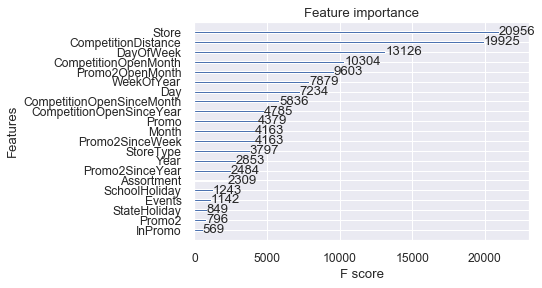

RMSPE on validation data:0.121665
success! 
 cost time: 1598.7972633838654 (s)


In [105]:
start_time = time.time()
model_3 = XGBoost_fit_model_3(X_train,X_val,y_train,y_val)

# 对验证集进行预测
y_pred_3 = model_3.predict(X_val)

# 对测试集进行预测
y_proba_3 = model_3.predict(data_test_store)
cost_time = time.time()-start_time
print('success!','\n','cost time:',cost_time,'(s)')

No handles with labels found to put in legend.


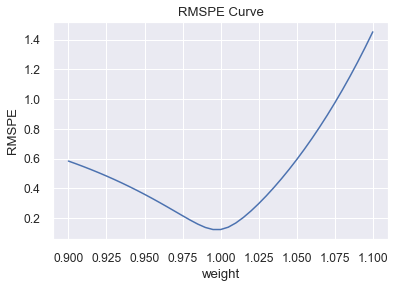

Best weight is 1.0, RMSPE is 0.1217


In [113]:
# weights = np.arange(0.9, 1.1, 0.005)
errors_3 = []
for w in weights:
    error_3 = rmspe(np.expm1(y_val), np.expm1(y_pred_3*w))
    errors_3.append(error_3)
    
fig, ax = plt.subplots()
ax.plot(weights,errors_3)
ax.set(ylabel='RMSPE', xlabel='weight', title='RMSPE Curve')
ax.legend()
plt.show()

idx = errors_3.index(min(errors_3))
weight_3 = weights[idx]
print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors_3)))

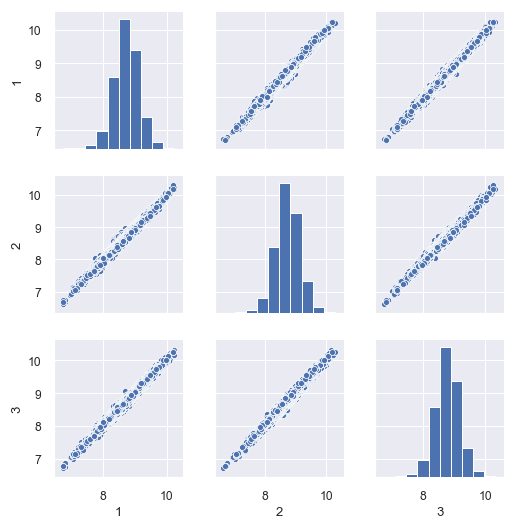

In [114]:
# 3个模型已完成训练，分析这3个模型的相关性
preds_total = pd.DataFrame()
preds_total[1] = y_pred_1 * weight_1
preds_total[2] = y_pred_2 * weight_2
preds_total[3] = y_pred_3 * weight_3

sns.pairplot(preds_total)

In [115]:
# - 从上图看，模型有一定相关性，但也有区别。

# 模型融合常见的策略有：平均法、投票法和学习法。平均法有简单平均法和加权平均法。

#简单平均融合
print ('简单平均融合——Validating')
weight = np.array([0.33333,0.33333,0.33333])
bagged_preds_2 = np.dot(preds_total,weight)
bagged_error_2 = rmspe(np.expm1(y_val), np.expm1(bagged_preds_2))
print('RMSPE for weight: {:.6f}'.format(bagged_error_2))
# bagged_preds_1 = preds_total.mean(axis = 1)
# bagged_error_1 = rmspe(np.expm1(y_val), np.expm1(bagged_preds_1))
# print('RMSPE for mean: {:.6f}'.format(bagged_error_1))

简单平均融合——Validating
RMSPE for weight: 0.116765


In [117]:
#加权平均融合
print ('加权平均融合——Validating')  
weight = np.array([0.6,0.1,0.3])
bagged_preds_2 = np.dot(preds_total,weight)
bagged_error_2 = rmspe(np.expm1(y_val), np.expm1(bagged_preds_2))
print('RMSPE for weight: {:.6f}'.format(bagged_error_2))

加权平均融合——Validating
RMSPE for weight: 0.116252


In [118]:
# make submission
print("Make predictions on the test set")
y_proba_total = pd.DataFrame()
y_proba_total[1] = y_proba_1 * weight_1
y_proba_total[2] = y_proba_2 * weight_2
y_proba_total[3] = y_proba_3 * weight_3

#均值融合
bagged_proba_1 = y_proba_total.mean(axis = 1)
result_data = pd.DataFrame({'Id': data_test['Id'], 'Sales': np.expm1(bagged_proba_1)})
result_data.to_csv('submission_mean.csv', index=False)

#加权融合
bagged_proba_2 = np.dot(y_proba_total,weight)
result_data = pd.DataFrame({'Id': data_test['Id'], 'Sales': np.expm1(bagged_proba_2)})
result_data.to_csv('submission_weight.csv', index=False)

Make predictions on the test set
